## 0. Setup

### User inputs

In [1]:
FINAL_PREDICTION_YEAR <- 2050 # year up to which long-term predictions are made
LINE_SIZE <- 2 # line size in ggplot
USE_TRAINED_MODELS <- TRUE # load neural network models from disk if possible
LSTM_LOOKBACK_LENGTH <- 3 # length of lookback window for LSTM

# age range GLM
MinAgeGLM <- 60
MaxAgeGLM <- 90

### Packages etc

In [2]:
# package management
if (!"renv" %in% installed.packages()) {
    install.packages("renv")
}

renv::restore()

suppressPackageStartupMessages({
    library(MortalityLaws)
    library(fst)
    library(dplyr)
    library(tidyr)
    library(rmarkdown)
    library(ggplot2)
    library(data.table)
    library(forecast)
    library(gridExtra)
    library(keras)
    library(zoo)
})

# seed
set.seed(42)
tensorflow::tf$random$set_seed(42)

# create folder for saving models
dir.create("models", showWarnings = FALSE)

# source utility functions (for plotting forecasts, calculating error measures, ...)
source("utils.R")

# globals
COUNTRIES <- c("AUS", "AUT", "BEL", "BGR", "BLR", "CAN", "CHE", "CHL", "CZE", "DEUTNP", "DNK", "ESP", "EST", "FIN", "FRATNP",
               "GBRTENW", "GBR_NIR", "GBR_SCO", "GRC", "HUN", "IRL", "ISL", "ITA", "JPN", "LTU", "LUX", "LVA", "NLD", "NOR",
               "NZL_NM", "POL", "RUS", "SVK", "SVN", "SWE", "TWN", "UKR", "USA")

# plots
options(repr.plot.width = 20, repr.plot.height = 8)

ggplot2::theme_set(ggplot2::theme_bw(base_size = 12) +
                   ggplot2::theme(panel.grid.major = ggplot2::element_blank(),
                                  panel.grid.minor = ggplot2::element_blank(),
                                  text = ggplot2::element_text(size = 35)))

* The library is already synchronized with the lockfile.


Loaded Tensorflow version 2.9.1



## 1. Load and prepare mortality data

Warning message in mask$eval_all_mutate(quo):
"NAs durch Umwandlung erzeugt"
Warning message in mask$eval_all_mutate(quo):
"NAs durch Umwandlung erzeugt"


,Country,Year,Age,Sex,mx,Dx,Ex,log_mx
,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AUS,1950,0,Female,0.022343,2004.35,89707.97,-3.801242
2,AUS,1950,0,Male,0.028362,2662.40,93871.95,-3.562705
3,AUS,1950,1,Female,0.002739,238.04,86892.88,-5.900162
4,AUS,1950,1,Male,0.003026,275.14,90918.15,-5.800514
5,AUS,1950,2,Female,0.001019,90.02,88341.23,-6.888934
6,AUS,1950,2,Male,0.001814,168.09,92640.39,-6.312221


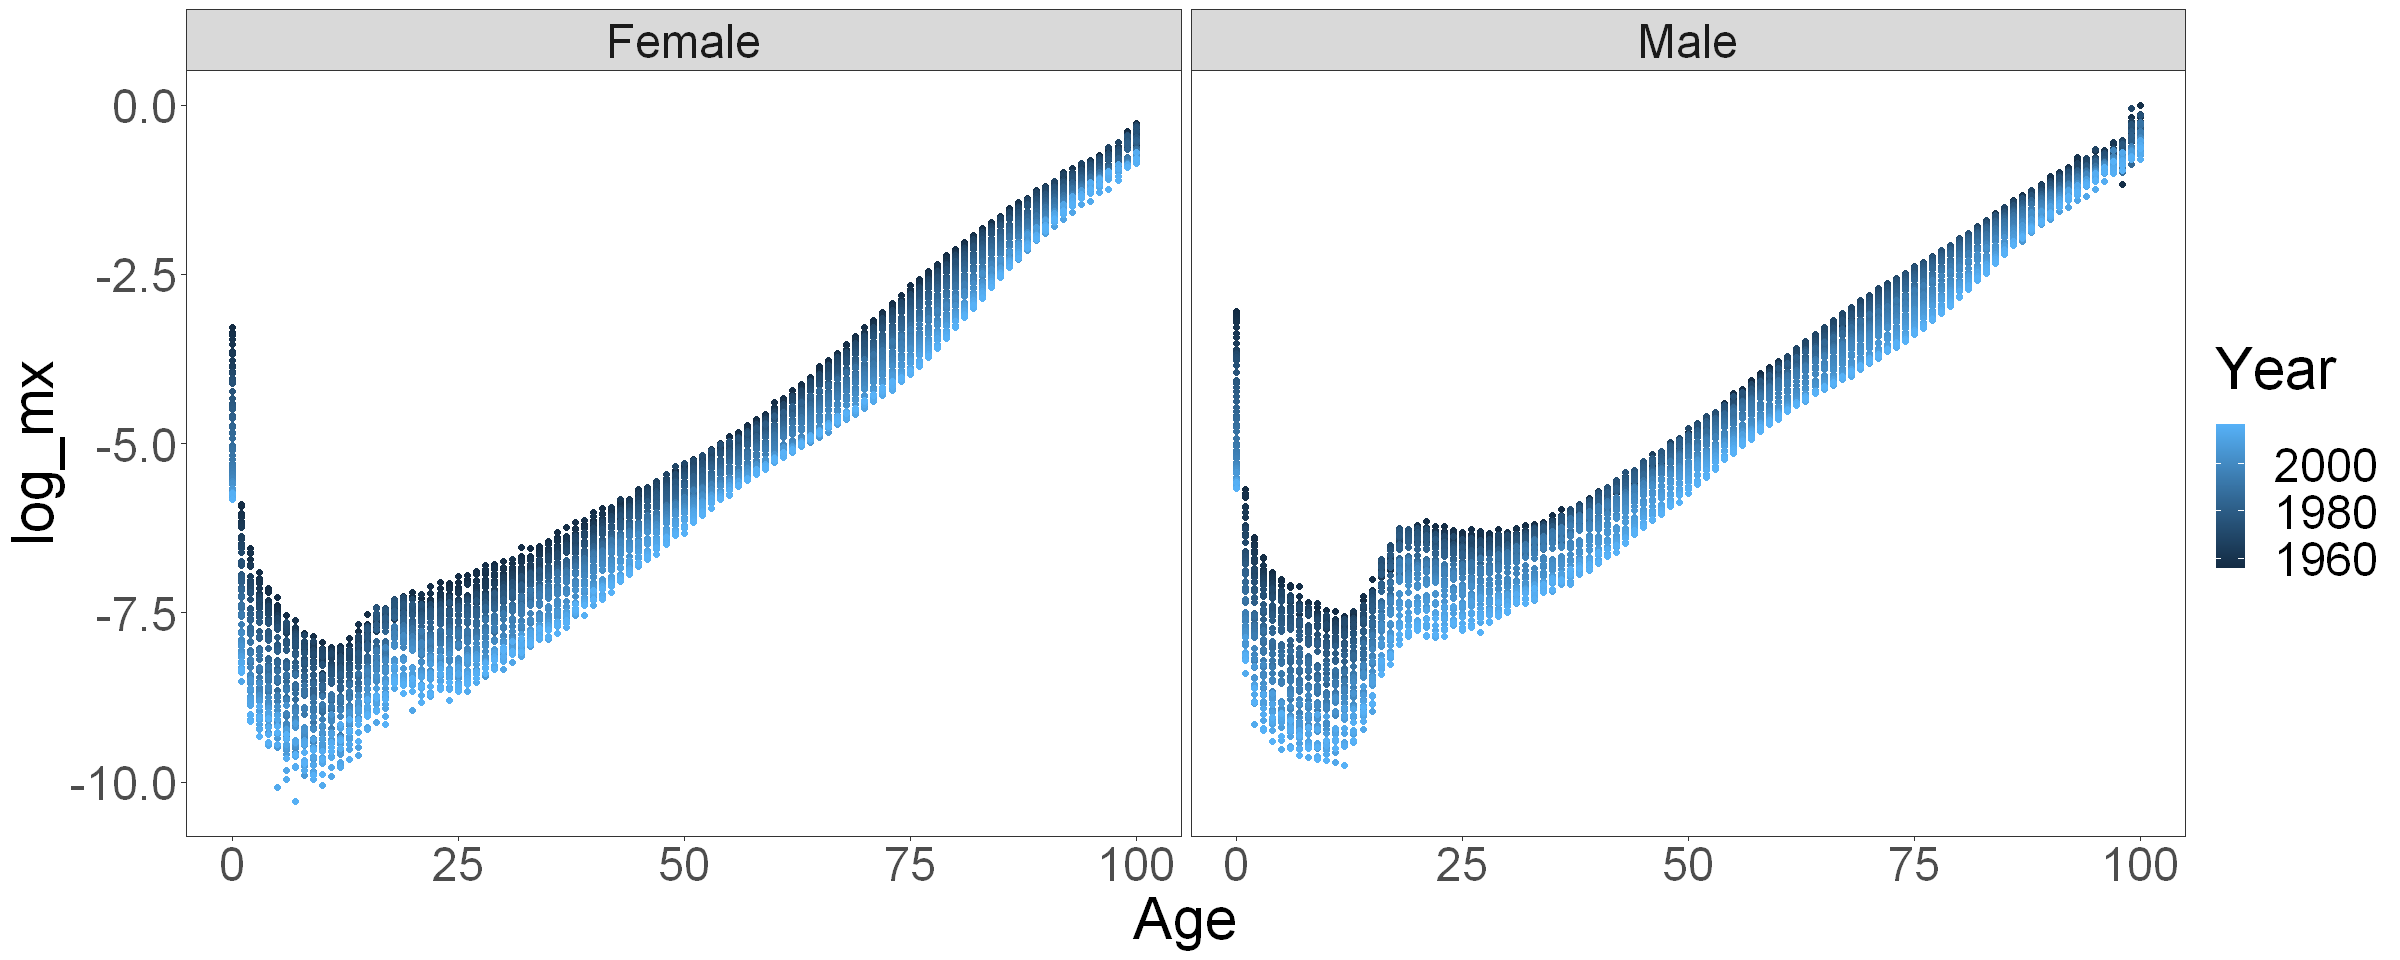

In [3]:
# load
df <- fst::read.fst("mortality_data.fst") %>%
  dplyr::mutate(dplyr::across(c(mx, Dx, Ex), as.numeric))

# filter
df_filtered <- df %>%
  filter(Country %in% c(COUNTRIES, "DEUTE", "DEUTW"),
         Age %in% 0:100,
         Year %in% 1950:2017,
         Sex %in% c("Male", "Female"))

# calculate DEUTNP before 1990 from DEUTW and DEUTE 
minYearGermany <- min(df_filtered %>% filter(Country == "DEUTNP") %>% pull(Year)) # 1990

df_filtered <- df_filtered %>%
  dplyr::bind_rows(df_filtered %>%
              dplyr::filter(Country %in% c("DEUTW", "DEUTE"), Year < minYearGermany) %>%
              dplyr::mutate(Country = "DEUTNP") %>%
              dplyr::group_by(Country, Sex, Age, Year) %>%
              dplyr::summarize(Dx = sum(Dx), Ex = sum(Ex), .groups = "drop_last") %>%
              dplyr::mutate(mx = Dx / Ex)
  ) %>%
  dplyr::filter(Country != "DEUTW", Country != "DEUTE") %>%
  dplyr::arrange(Country, Year, Age, Sex)

# if mortality rate is zero or missing, use average rate at that age, sex, year over all countries
df_average <- df_filtered %>%
  dplyr::group_by(Age, Sex, Year) %>%
  dplyr::summarize(average_mx = mean(mx, na.rm = TRUE), .groups = "drop_last")

df_filtered <- df_filtered %>%
  dplyr::left_join(df_average, by = c("Age", "Sex", "Year")) %>%
  dplyr::mutate(mx = ifelse(is.na(mx) | mx == 0, average_mx, mx)) %>%
  dplyr::select(-average_mx)

# now we can calculate log mortality
df_filtered <- df_filtered %>%
  dplyr::mutate(log_mx = log(mx))

# have a look at the data
head(df_filtered)

ggplot2::ggplot(df_filtered %>% 
                  dplyr::filter(Country == "DEUTNP"),
                ggplot2::aes(x = Age, y = log_mx, color = Year)) +
  ggplot2::geom_point() + 
  ggplot2::facet_wrap(~Sex)

### Train-test split

In [4]:
df_train <- df_filtered %>%
  dplyr::filter(Year < 2000)
df_test <- df_filtered %>%
  dplyr::filter(Year >= 2000)

# add years to df_test to get up to 2049
for (country in unique(df_test$Country)) {
    df_test_country <- df_test %>% filter(Country == country)
    df_test <- df_test %>%
      dplyr::bind_rows(
        expand.grid(Year = (max(df_test_country$Year) + 1):FINAL_PREDICTION_YEAR, 
                Age = unique(df_test_country$Age),
                Country = country,
                Sex = unique(df_test_country$Sex))
      ) 
}

df_test <- df_test %>%
  dplyr::arrange(Country, Year, Age, Sex)

## 2. Individual Lee-Carter models

### Fit and forecast 
code adapted from https://github.com/DeutscheAktuarvereinigung/Mortality_Modeling/blob/master/DAV%20Use%20Case%20Mortality%20Modeling-Final_V3.ipynb

In [5]:
fit_lc <- function(df) {
    df <- data.table::as.data.table(df)
    
    # fit Lee Carter model via SVD to the selected country/sex 
    df[, ax := mean(log_mx), by = (Age)]
    df[, mx_adj := log_mx - ax]  
    rates_mat <- as.matrix(df %>% data.table::dcast.data.table(Age~Year, value.var = "mx_adj", sum))[, -1]
    svd_fit <- svd(rates_mat)
    ax <- df[, unique(ax)]
    bx <- svd_fit$u[, 1] * svd_fit$d[1]
    kt <- svd_fit$v[, 1]
    c1 <- mean(kt)
    c2 <- sum(bx)
        
    # implement identifiability constraints
    ax <- ax + c1 * bx
    bx <- bx / c2
    kt <- (kt - c1) * c2
    
    names(ax) <- unique(df$Age)
    names(bx) <- unique(df$Age)
    names(kt) <- unique(df$Year)
    
    return(list(ax = ax, bx = bx, kt = kt))
}

extrapolate_kt_rwd <- function(kt, h) {
    forecast_kt <- kt %>% forecast::rwf(h, drift = T)
    
    return(forecast_kt$mean)
}

forecast_LC_based_on_kt <- function(model, kt) {
    pred_LC <- (model$ax + (model$bx) %*% t(kt)) %>% 
      reshape2::melt()
    return(pred_LC$value %>% exp())
}

In [6]:
lc_models <- list()
lc_prediction_list <- list()

for (country in unique(df_train$Country)) {
    lc_local <- list()
    
    for (sex in unique(df_train$Sex)) {
        # fit model
        df_train_local <- df_train %>%
          dplyr::filter(Country == country, Sex == sex)
        
        model <- fit_lc(df_train_local)
        lc_models[[paste(country, sex, sep = "-")]] <- model
        
        # extrapolation (random walk with drift)
        df_test_local <- df_test %>%
              dplyr::filter(Country == country, Sex == sex) 
        n_forecast_years <- dplyr::n_distinct(df_test_local$Year)
        kt_forecast <- extrapolate_kt_rwd(model$kt, n_forecast_years)
        df_test_local$mx_prediction <- forecast_LC_based_on_kt(model, kt_forecast)
        
        lc_local[[sex]] <- df_test_local
    }
    
    lc_prediction_list[[country]] <- data.table::rbindlist(lc_local)
}

lc_prediction <- data.table::rbindlist(lc_prediction_list)

### Let's have a look at the LC parameters.

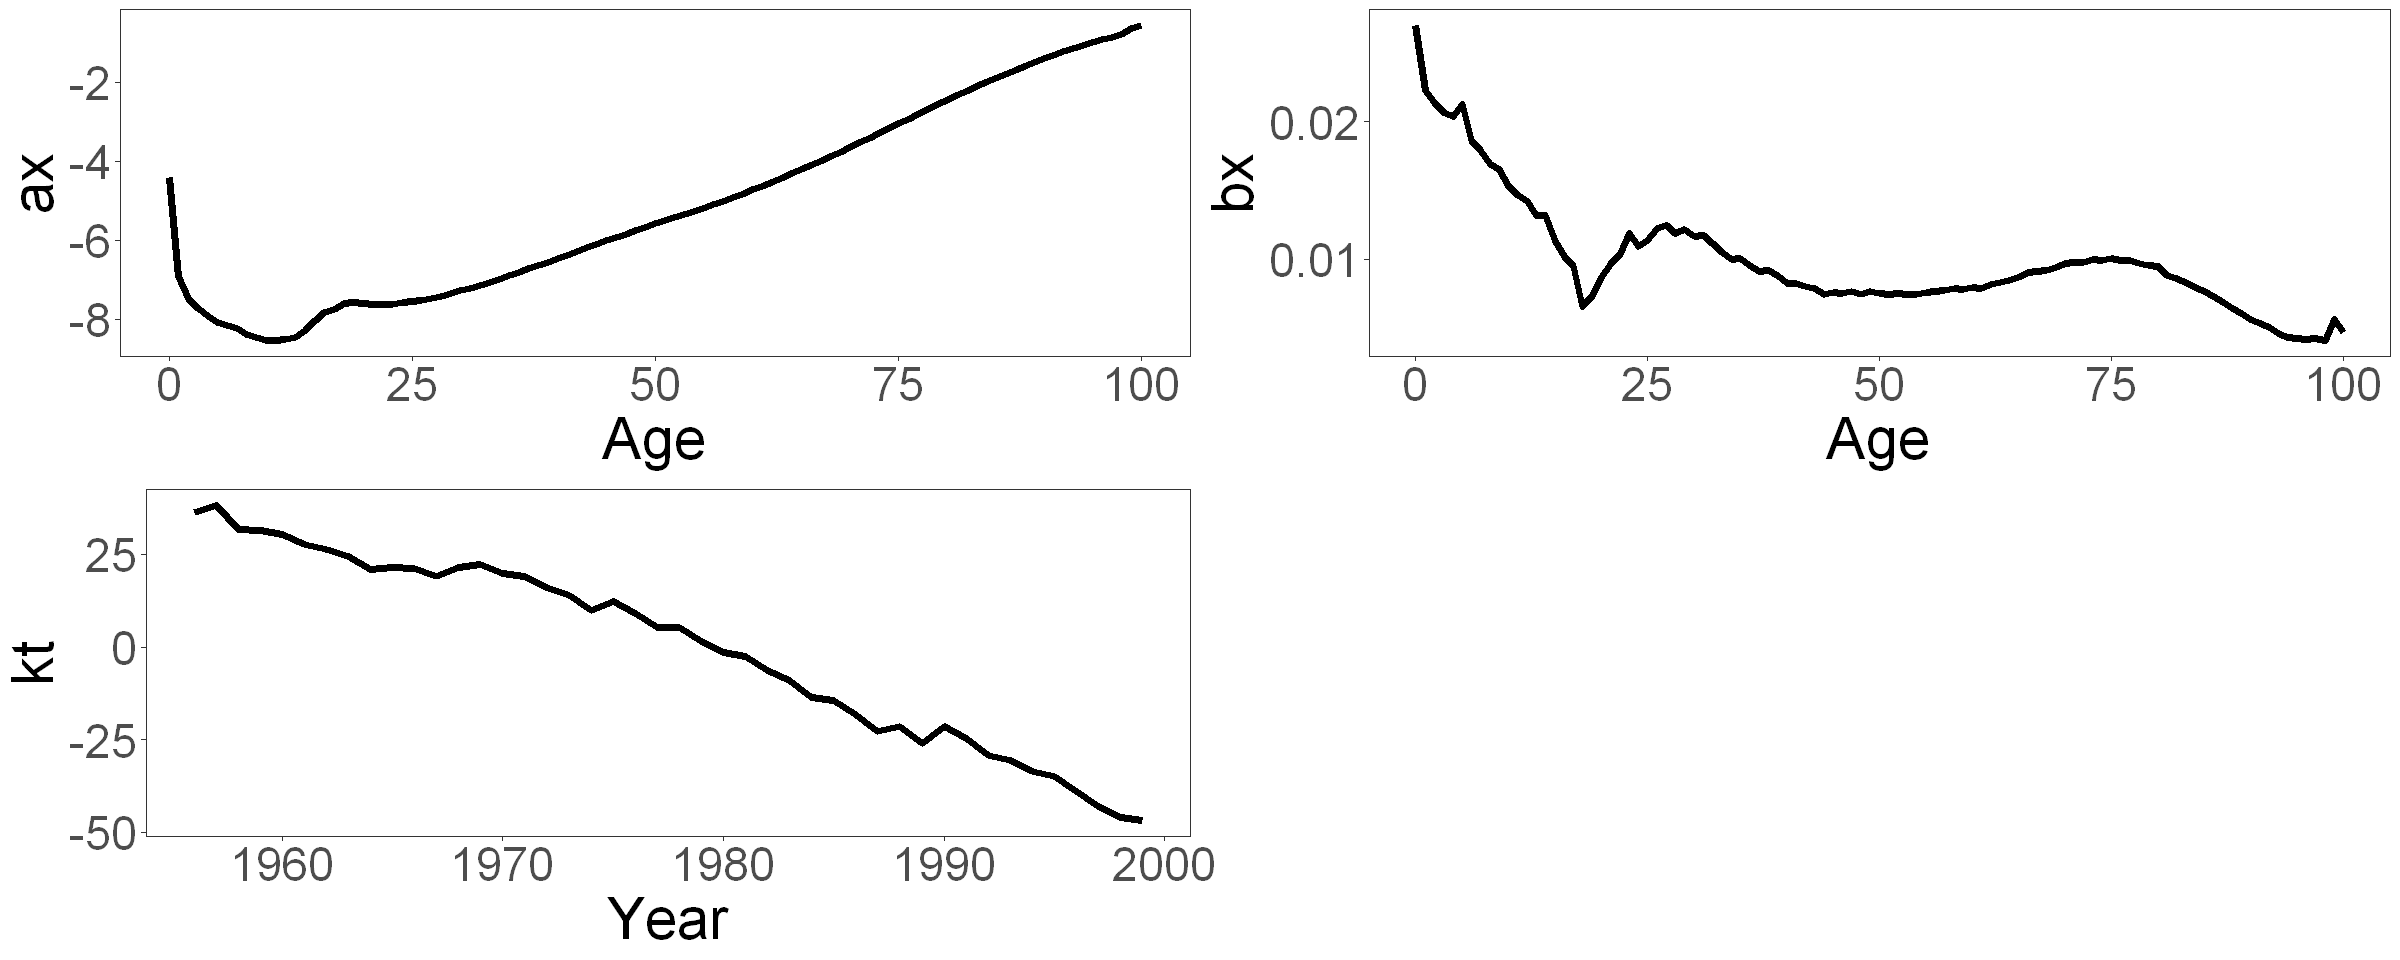

In [7]:
plot_LC_parameters(lc_models[["DEUTNP-Female"]])

### LC forecasts and error measures

[1] "Forecasts look like this"


Country,Year,Age,Sex,mx,Dx,Ex,log_mx,mx_prediction
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AUS,2000,0,Female,0.004656,570.01,122431.0,-5.369599,0.0048671075
AUS,2000,1,Female,0.000438,54.00,123243.5,-7.733292,0.0004141439
AUS,2000,2,Female,0.000227,28.00,123599.4,-8.390561,0.0002550114
AUS,2000,3,Female,0.000159,20.00,125459.9,-8.746606,0.0001886083
AUS,2000,4,Female,0.000127,16.00,126205.0,-8.971323,0.0001658359
AUS,2000,5,Female,0.000155,20.00,129364.9,-8.772085,0.0001242072


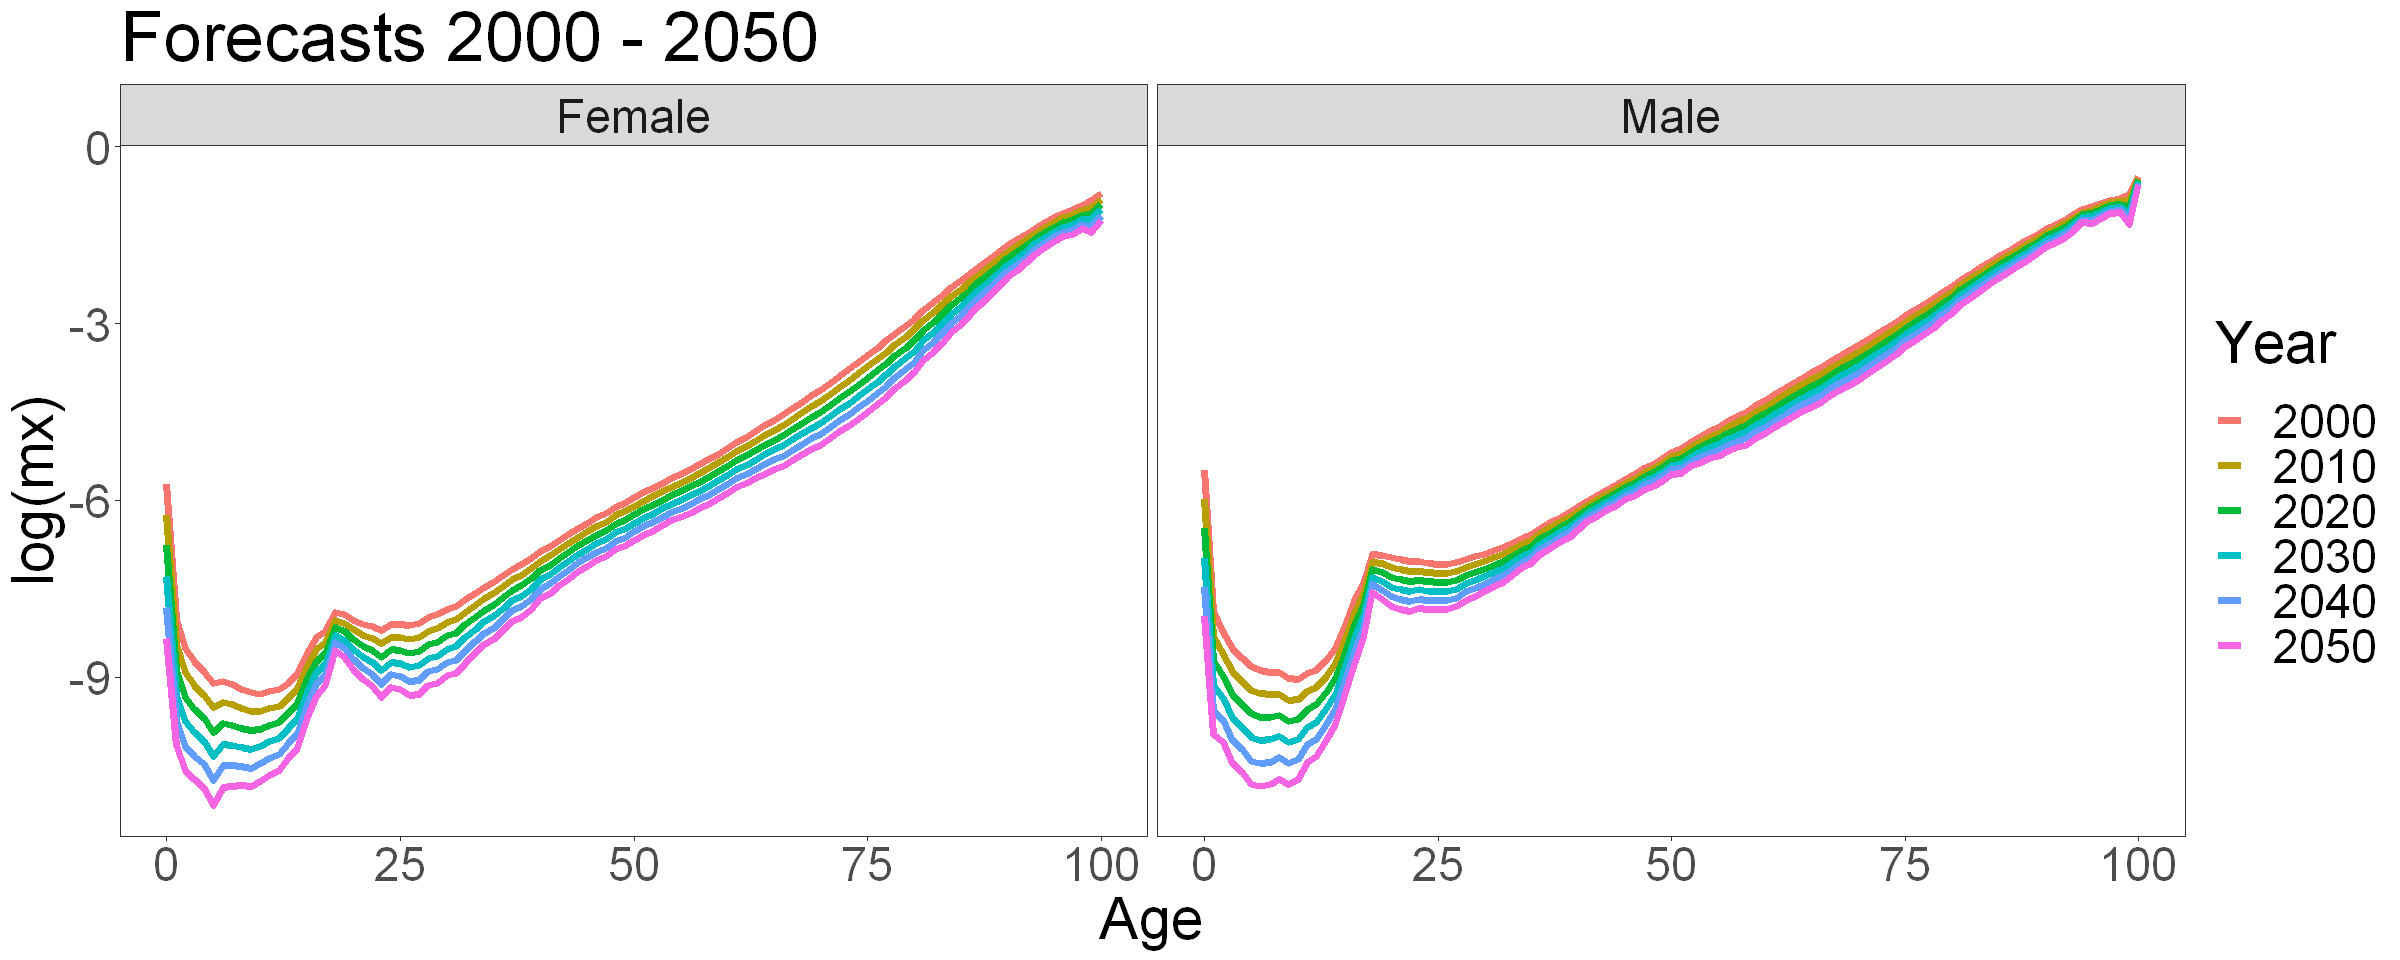

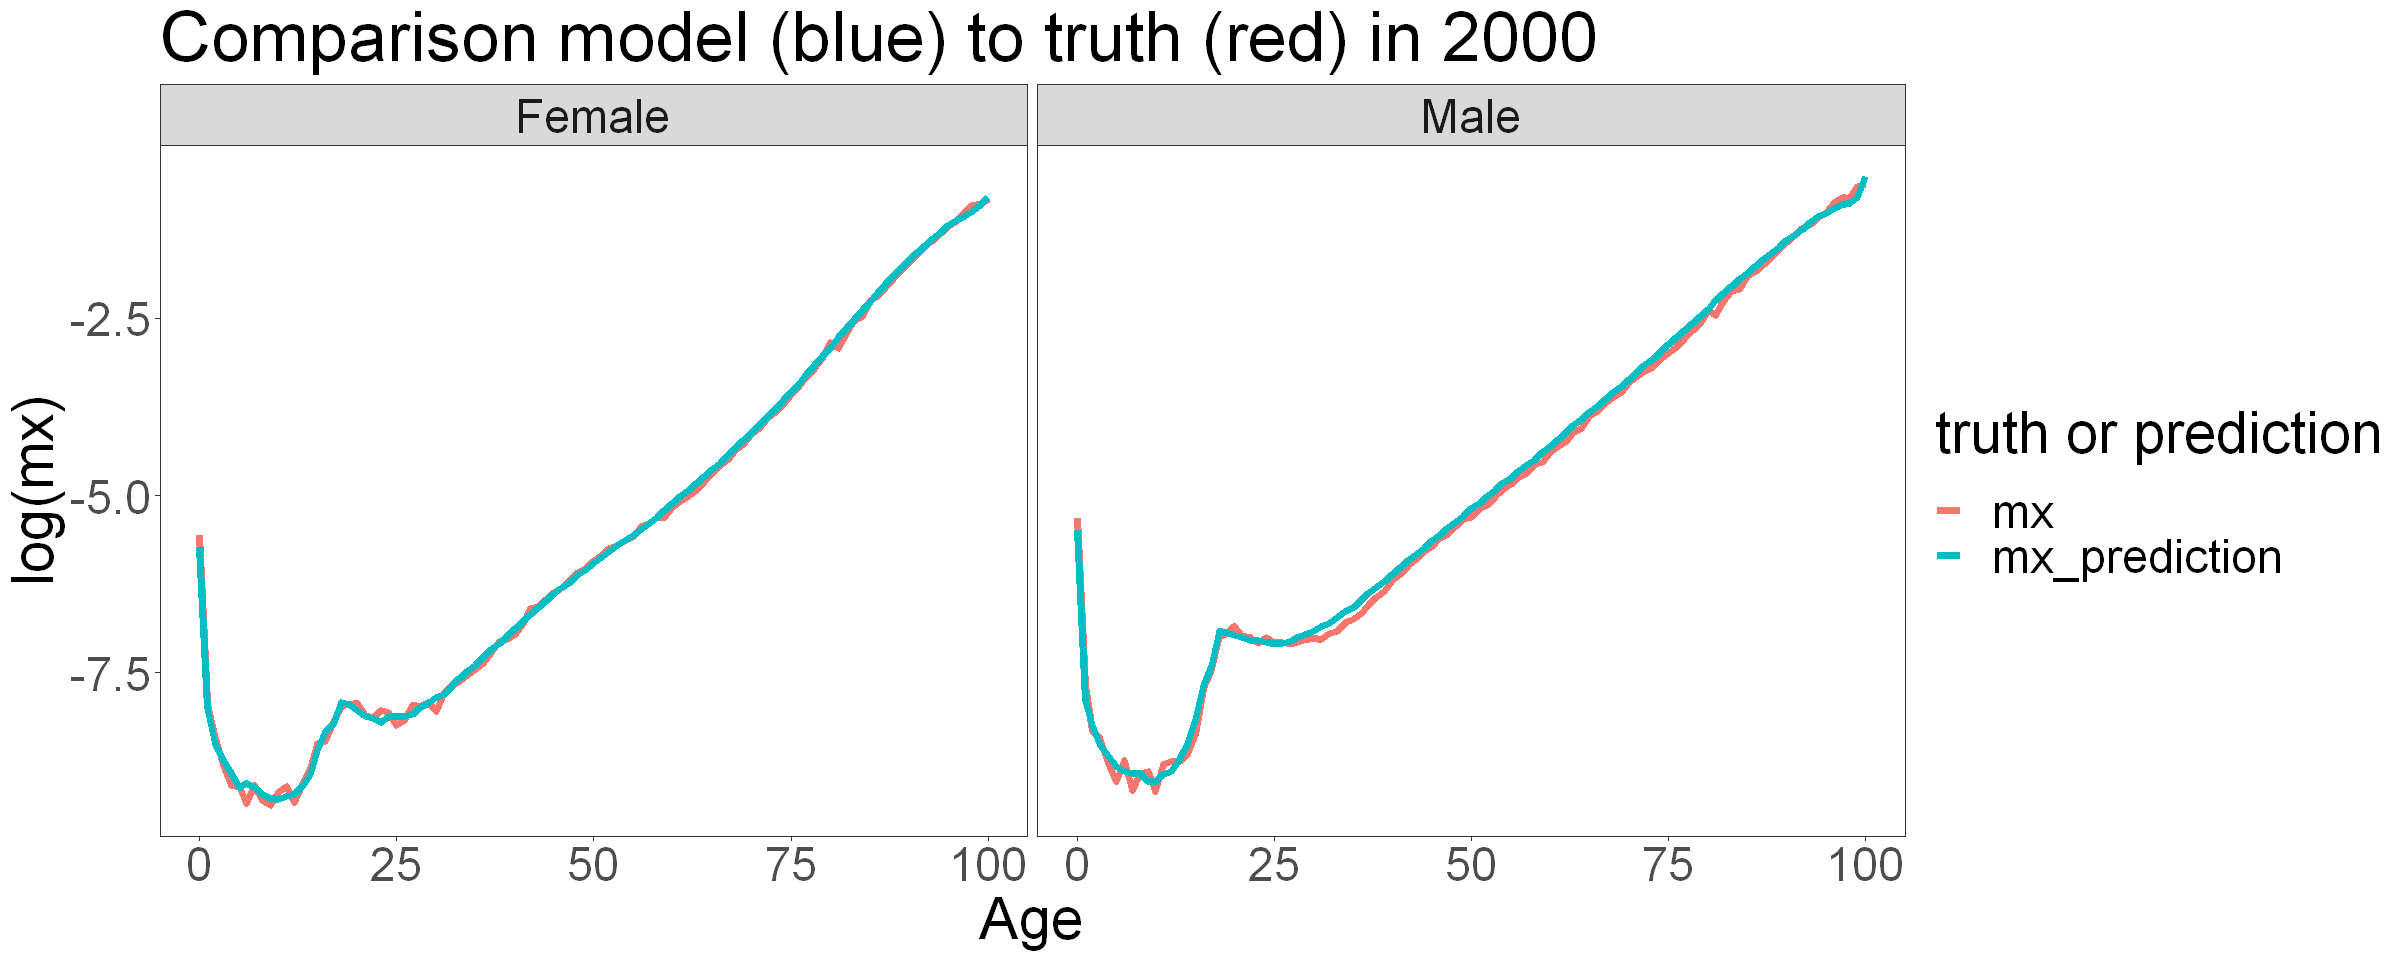

[1] "Total error measures"


MSE,MAPE
<dbl>,<dbl>
0.001002,0.2934


[1] "Error measures for age group 60-90"


MSE,MAPE
<dbl>,<dbl>
0.000251,0.2079


[1] "Error measures by country-sex group"


Country,Sex,MSE,MAPE
<chr>,<chr>,<dbl>,<dbl>
USA,Female,0.000067,0.1034
CAN,Female,0.000090,0.1086
DEUTNP,Female,0.000090,0.1099
ITA,Female,0.000038,0.1104
USA,Male,0.000068,0.1180
JPN,Male,0.000111,0.1391
GBRTENW,Female,0.000039,0.1394
FRATNP,Female,0.000053,0.1494
NLD,Female,0.000107,0.1517


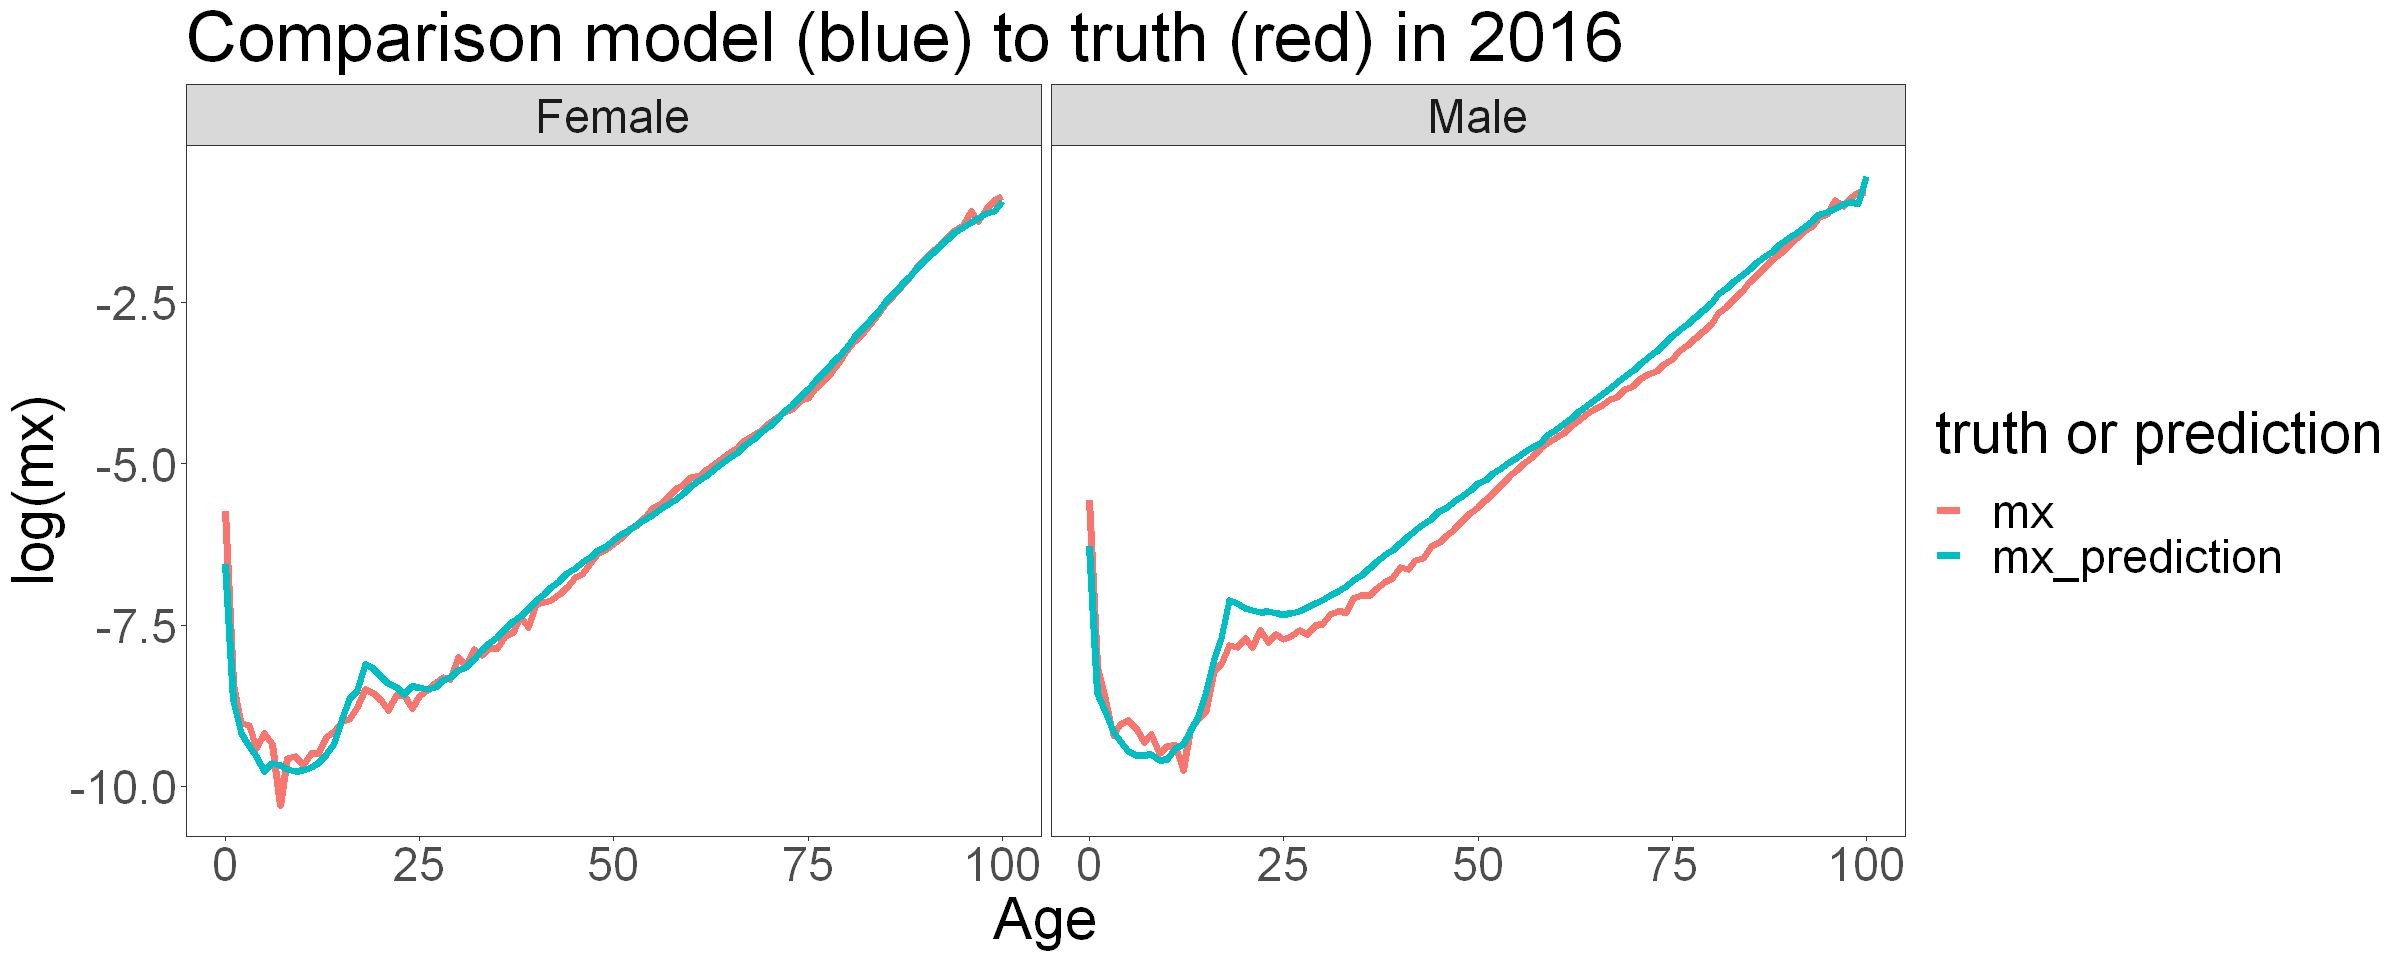

In [8]:
print("Forecasts look like this")
lc_prediction %>% head()

plot_all_forecasts(lc_prediction, country = "DEUTNP", years = seq(2000, 2050, by = 10))
plot_comparison_for_year(lc_prediction, country = "DEUTNP", year = 2000)
plot_comparison_for_year(lc_prediction, country = "DEUTNP", year = 2016)

print("Total error measures")
lc_errors_total <- calculate_error_measures(lc_prediction, groups = NULL)
lc_errors_total

print("Error measures for age group 60-90")
lc_errors_60_90 <- calculate_error_measures(lc_prediction %>% dplyr::filter(Age >= 60 & Age <= 90), groups = NULL)
lc_errors_60_90 

print("Error measures by country-sex group")
lc_errors_country_sex <- calculate_error_measures(lc_prediction, groups = c("Country", "Sex")) %>%
  dplyr::arrange(MAPE)
lc_errors_country_sex

## 3. GLM for mortality forecast

### Fit the model log(D) = b_0 + b_1 t + ... + log(E)

In [9]:
# (somewhat) justify log-linearity assumption by only looking at a limited age range
df_train_glm <- df_train %>%
  dplyr::filter(Age >= MinAgeGLM & Age <= MaxAgeGLM)
df_test_glm <- df_test %>%
  dplyr::filter(Age >= MinAgeGLM & Age <= MaxAgeGLM)

# simple GLM - no interaction terms
model_glm <- glm(formula = round(Dx) ~ Year + Age + Country + Sex,
                 family = poisson(),
                 data = df_train_glm,
                 offset = log(Ex))

glm_prediction <- df_test_glm %>%
  dplyr::mutate(mx_prediction = model_glm %>% predict(df_test_glm, type = "response") / Ex)

summary(model_glm)
head(glm_prediction)


Call:
glm(formula = round(Dx) ~ Year + Age + Country + Sex, family = poisson(), 
    data = df_train_glm, offset = log(Ex))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-77.953   -3.718   -0.377    2.883  131.029  

Coefficients:
                 Estimate Std. Error  z value Pr(>|z|)    
(Intercept)     1.002e+01  8.370e-03  1196.91   <2e-16 ***
Year           -1.037e-02  4.241e-06 -2444.01   <2e-16 ***
Age             9.721e-02  7.195e-06 13510.88   <2e-16 ***
CountryAUT      1.427e-01  7.499e-04   190.26   <2e-16 ***
CountryBEL      1.012e-01  7.091e-04   142.78   <2e-16 ***
CountryBGR      2.374e-01  7.664e-04   309.71   <2e-16 ***
CountryBLR      1.463e-01  8.263e-04   177.00   <2e-16 ***
CountryCAN     -9.791e-02  6.657e-04  -147.07   <2e-16 ***
CountryCHE     -4.382e-02  8.578e-04   -51.09   <2e-16 ***
CountryCHL      4.575e-02  1.657e-03    27.60   <2e-16 ***
CountryCZE      3.254e-01  7.037e-04   462.41   <2e-16 ***
CountryDEUTNP   1.495e-01  5.456e-04  

,Country,Year,Age,Sex,mx,Dx,Ex,log_mx,mx_prediction
,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AUS,2000,60,Female,0.004759,396.00,83217.47,-5.347718,0.007580742
2,AUS,2000,60,Male,0.008166,697.14,85371.61,-4.807776,0.012299963
3,AUS,2000,61,Female,0.005740,466.01,81182.29,-5.160296,0.008354676
4,AUS,2000,61,Male,0.009962,822.16,82528.12,-4.608977,0.013555693
5,AUS,2000,62,Female,0.005788,457.01,78961.32,-5.151968,0.009207623
6,AUS,2000,62,Male,0.010165,810.16,79703.22,-4.588805,0.014939622


### GLM forecasts and error measures
(we need exposures to predict death rates in this model, so we cannot forecast beyond 2016)

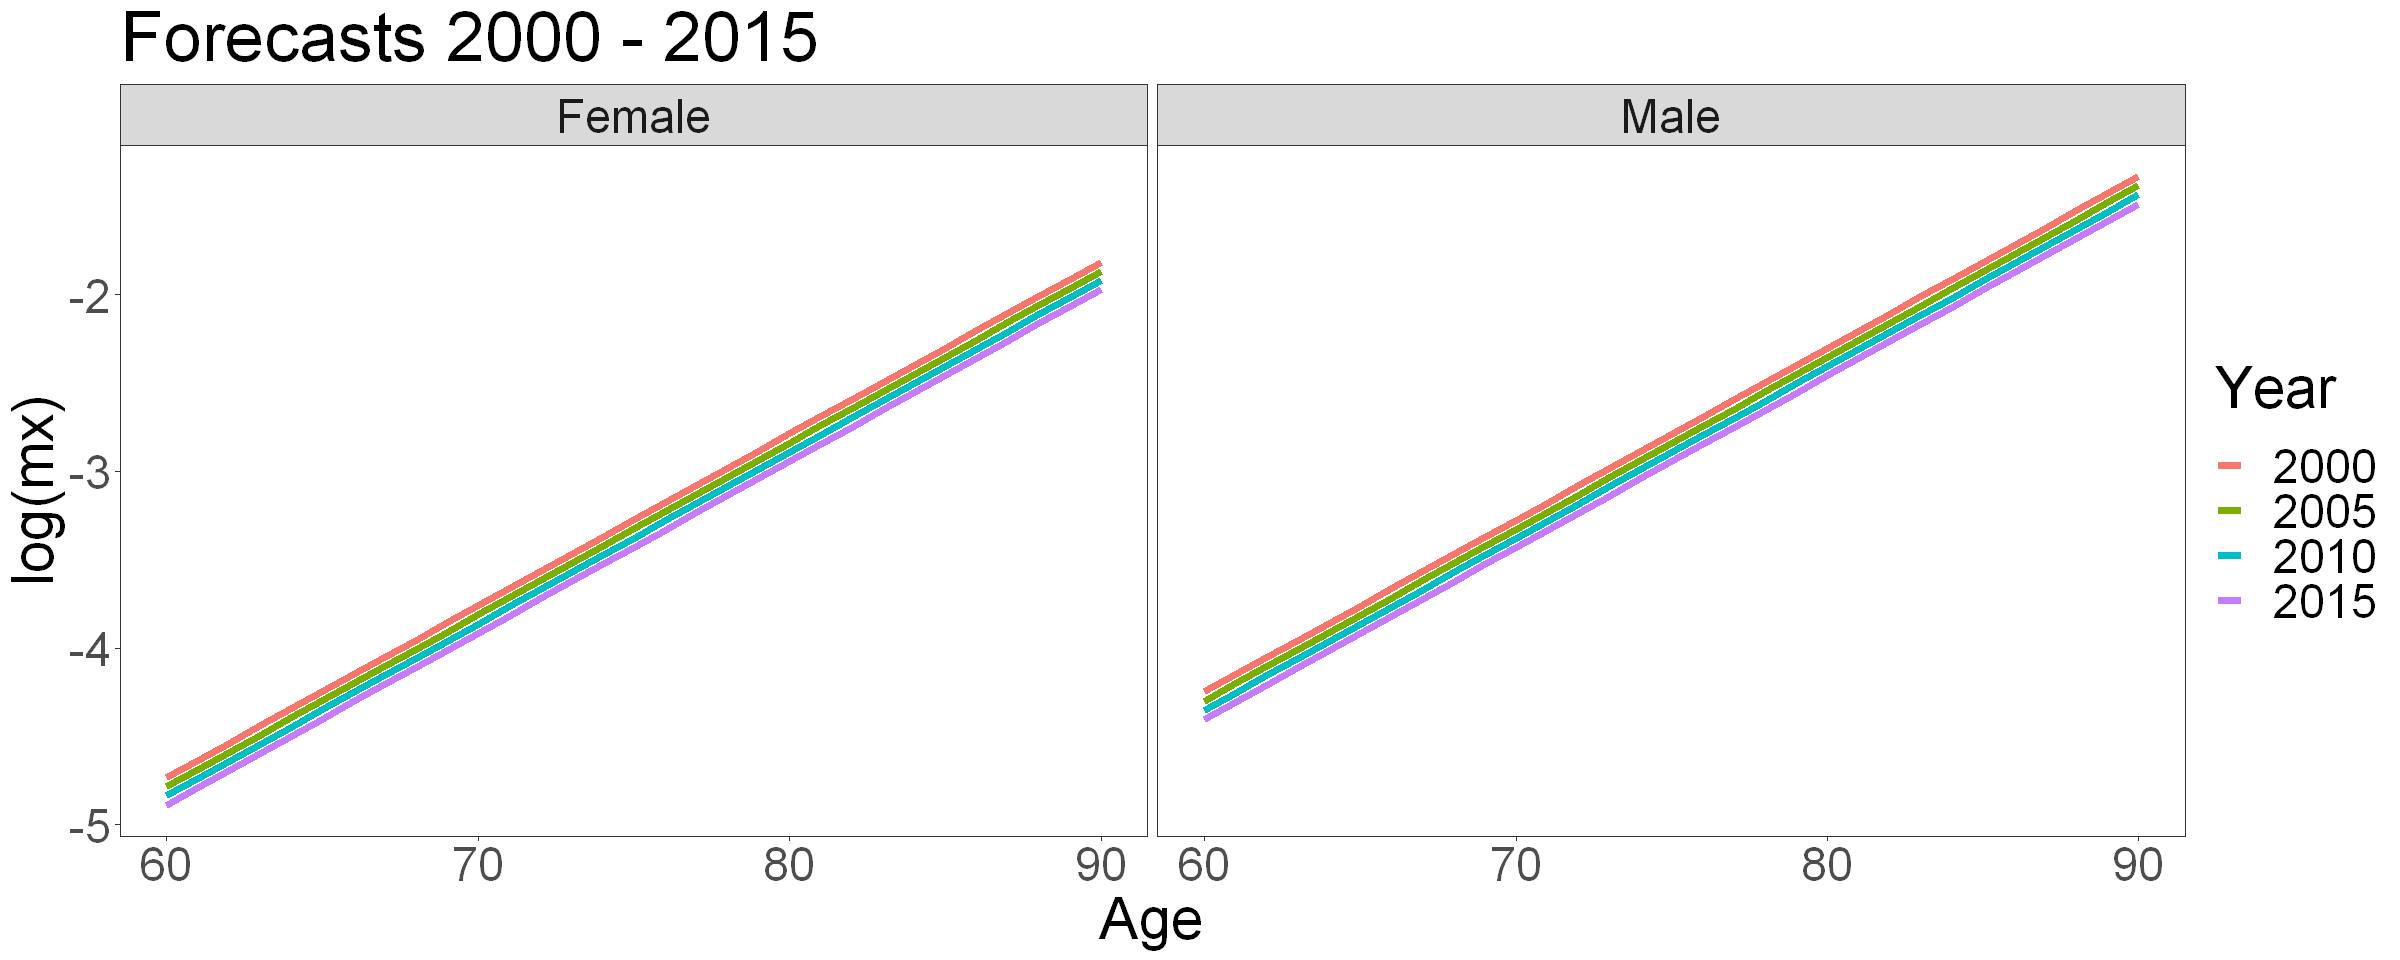

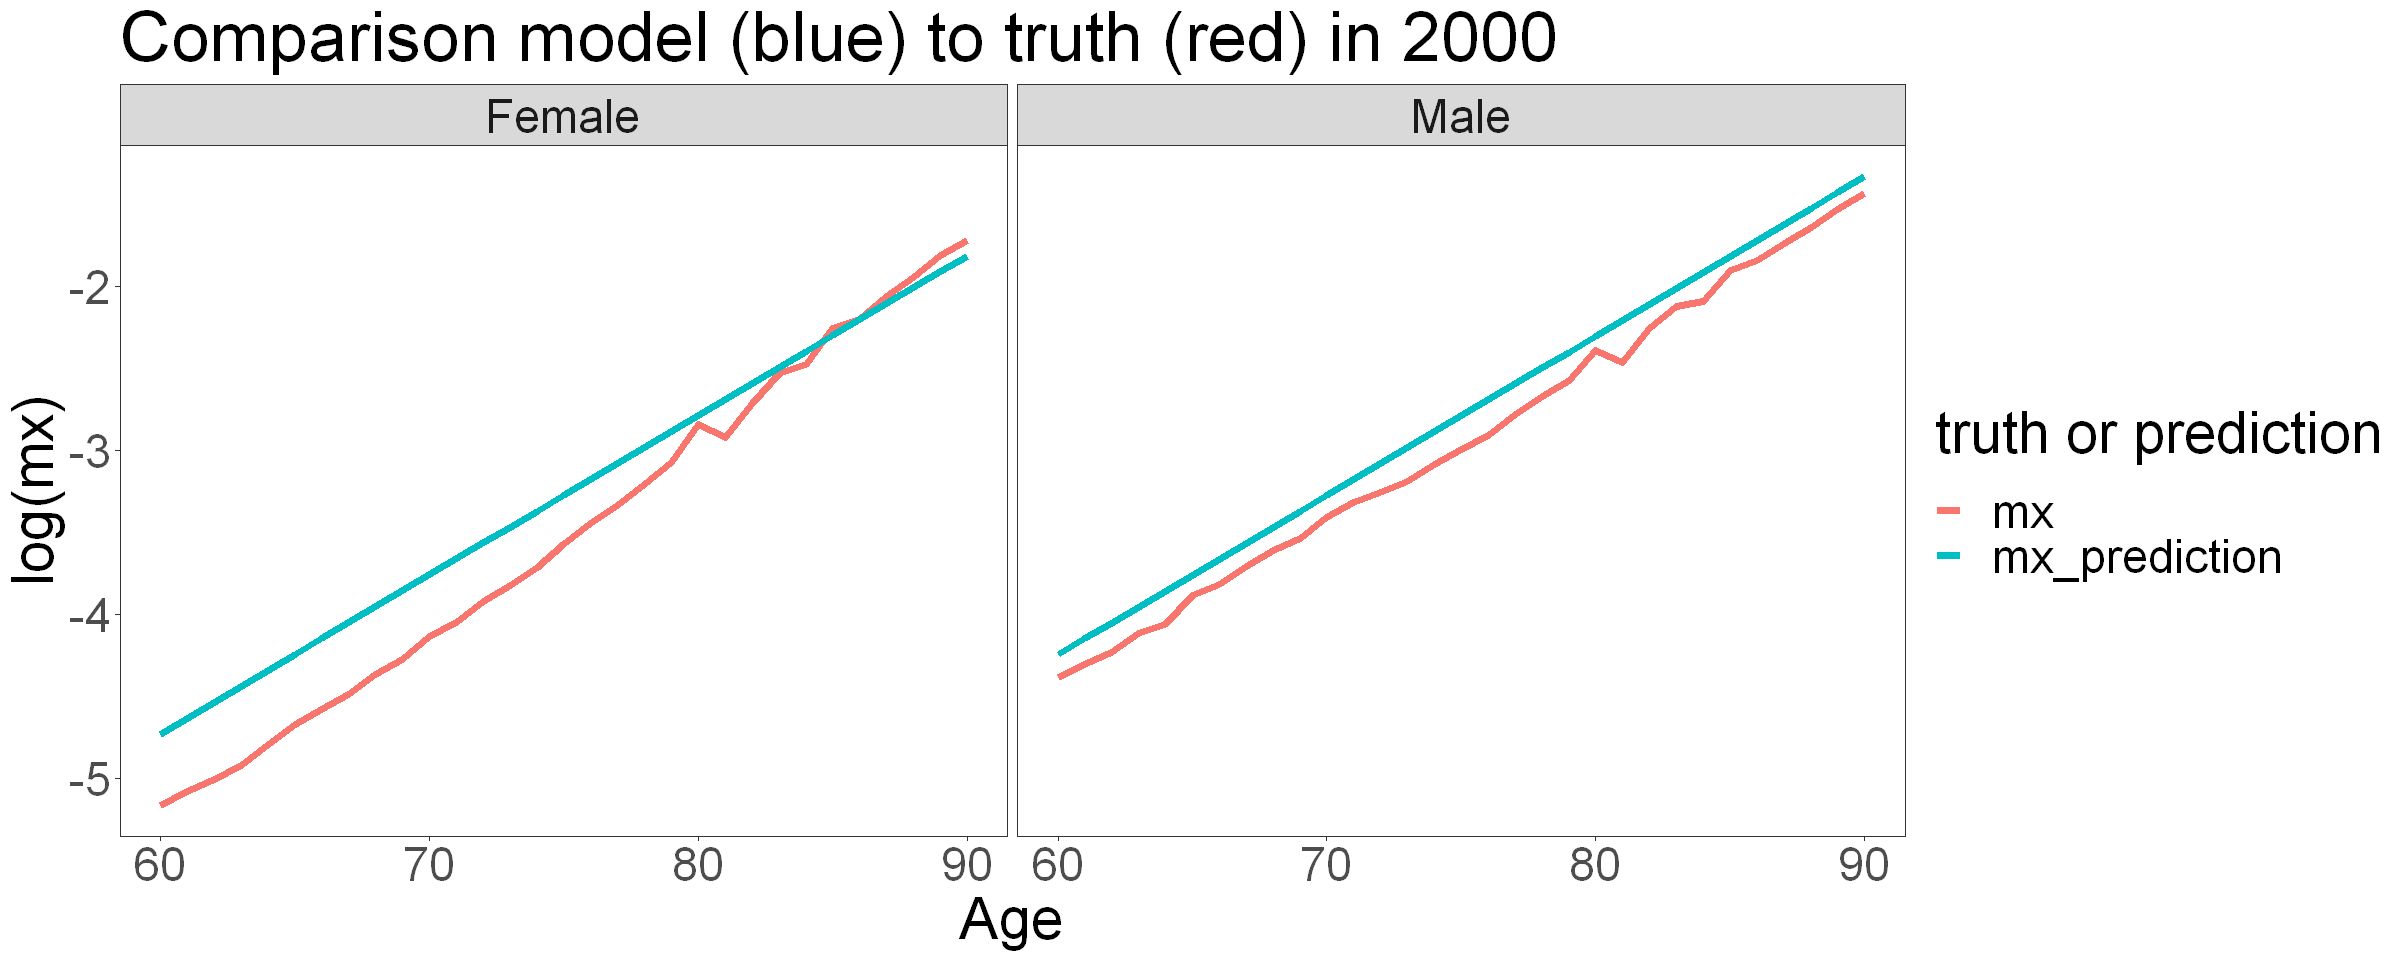

[1] "Total error measures"


MSE,MAPE
<dbl>,<dbl>
0.000239,0.2824


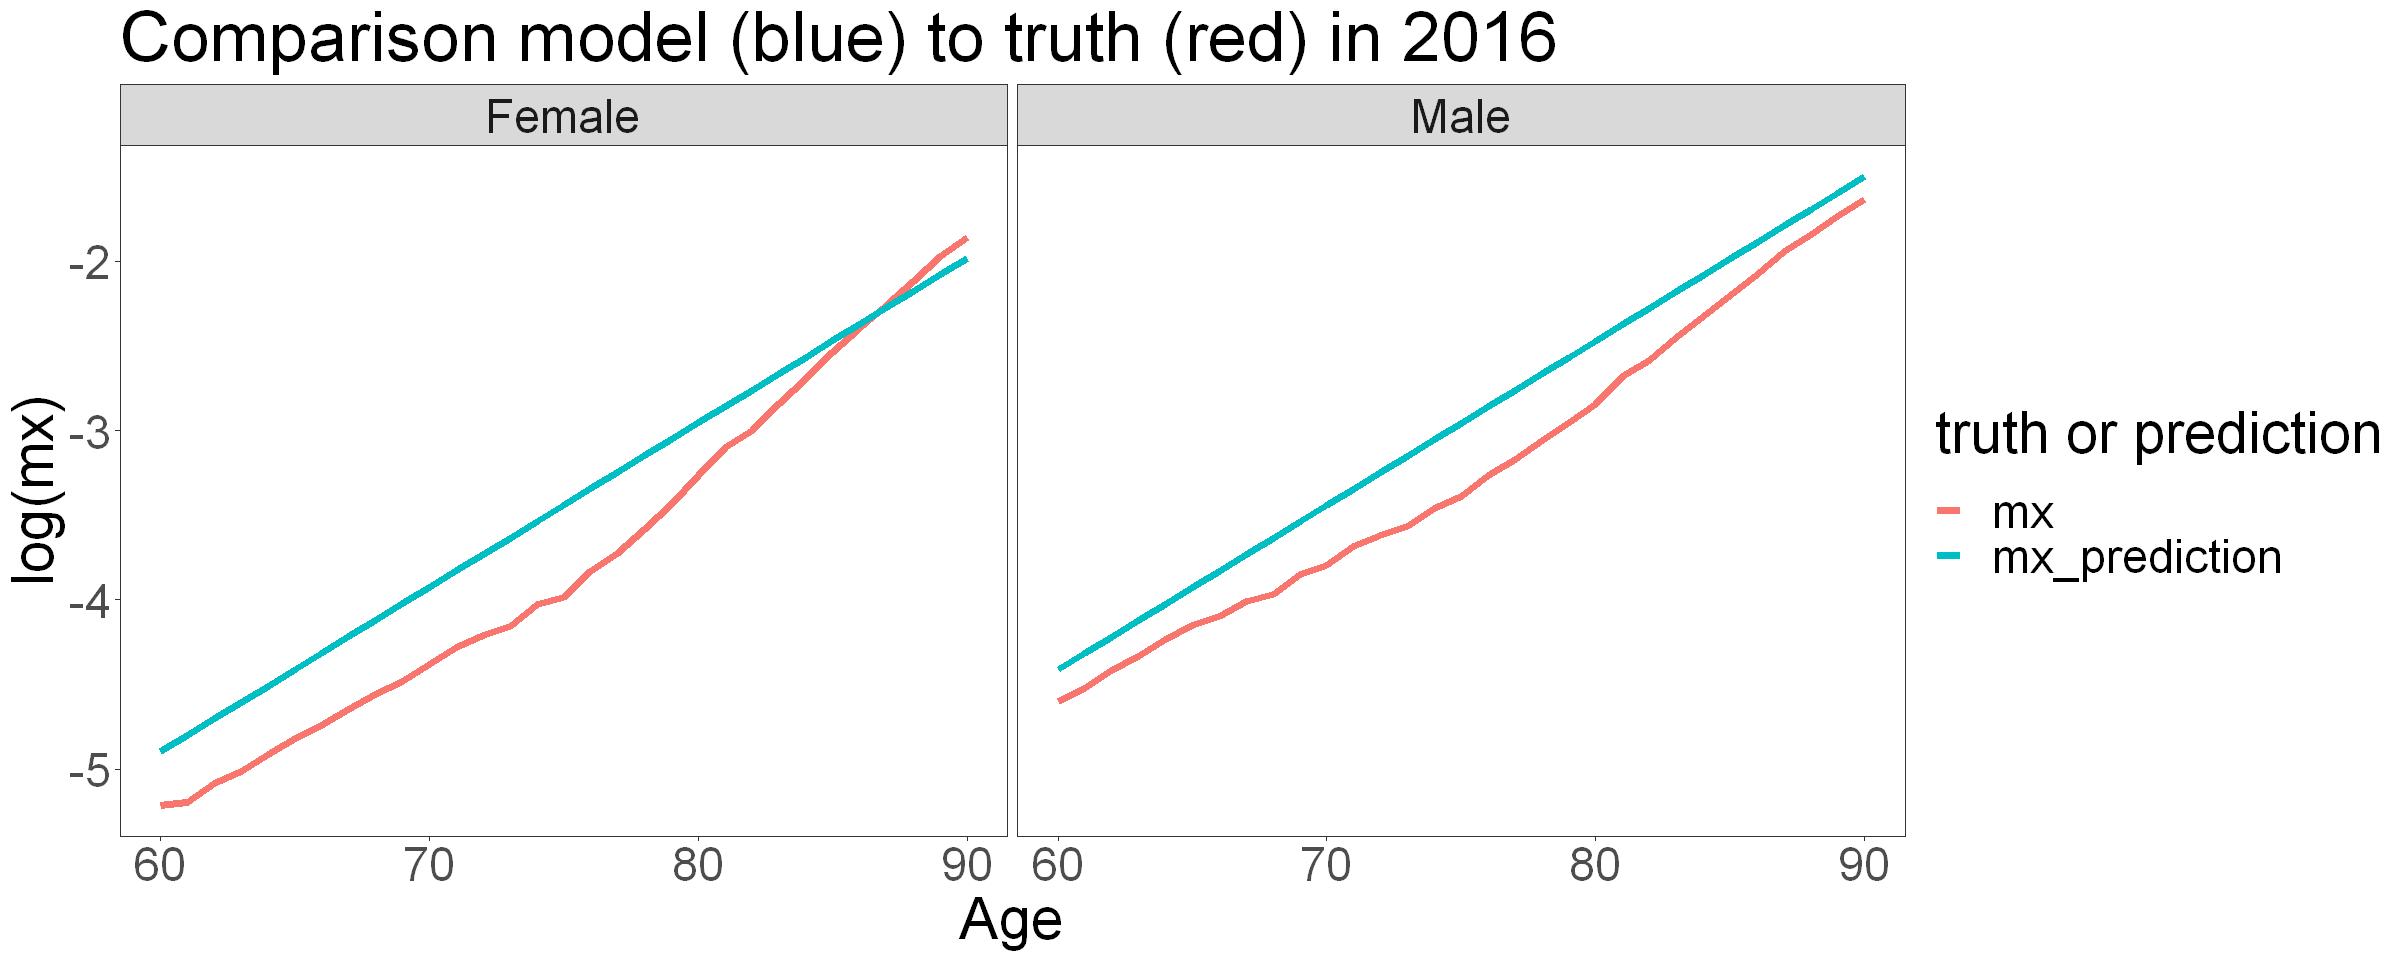

In [10]:
plot_all_forecasts(glm_prediction, country = "DEUTNP", years = seq(2000, 2015, by = 5))
plot_comparison_for_year(glm_prediction, country = "DEUTNP", year = 2000)
plot_comparison_for_year(glm_prediction, country = "DEUTNP", year = 2016)

print("Total error measures")
# MSE is not comparable to that of other models because we focus on age range 60-90 here
glm_errors_total <- calculate_error_measures(glm_prediction, groups = NULL)
glm_errors_total

## 4. Feed-forward neural network: Classification (MNIST)
code adapted from https://tensorflow.rstudio.com/tutorials/quickstart/beginner.html

### Load and prepare the MNIST data set

In [11]:
# load data; convert the sample data from integers to floating-point numbers
c(c(mnist_x_train, mnist_y_train), c(mnist_x_test, mnist_y_test)) %<-% keras::dataset_mnist()

dim(mnist_x_train)
mnist_x_train[1, , ]

mnist_x_train <- mnist_x_train / 255
mnist_x_test <-  mnist_x_test / 255

[1] 60000    28    28

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,175,26,166,255,247,127,0,0,0,0
0,0,0,0,0,0,0,0,30,36,⋯,225,172,253,242,195,64,0,0,0,0
0,0,0,0,0,0,0,49,238,253,⋯,93,82,82,56,39,0,0,0,0,0
0,0,0,0,0,0,0,18,219,253,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,80,156,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,14,⋯,0,0,0,0,0,0,0,0,0,0


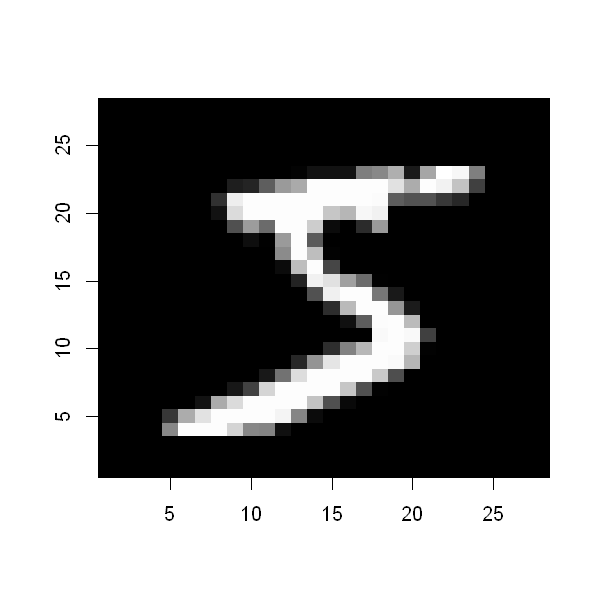

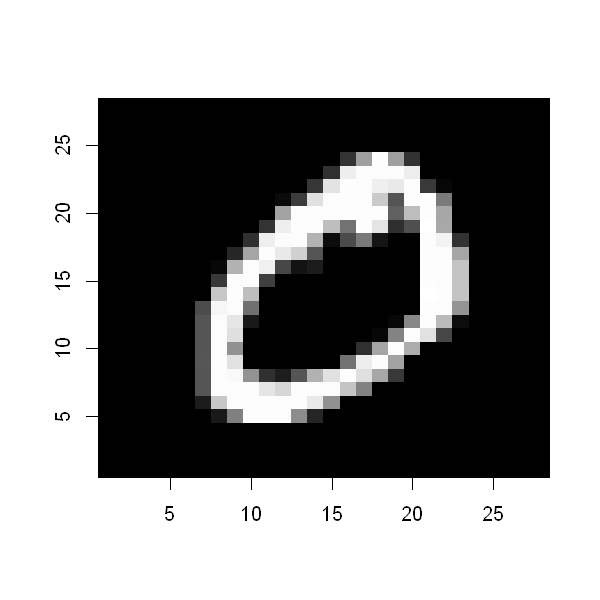

In [12]:
# plot first two images
options(repr.plot.width = 5, repr.plot.height = 5)
# for plotting, some manipulation (reverting and transposing) of the image data is necessary due to the plotting function
image(1:28, 1:28, mnist_x_train[1, , ] %>% apply(2, rev) %>% t(), col = gray((0:255) / 255), xlab = "", ylab = "")
image(1:28, 1:28, mnist_x_train[2, , ] %>% apply(2, rev) %>% t(), col = gray((0:255) / 255), xlab = "", ylab = "")
options(repr.plot.width = 20, repr.plot.height = 8)

### Build a neural net for classification

In [13]:
# build a neural network
mnist_ffnn_model <- keras::keras_model_sequential(input_shape = c(28, 28)) %>%
  keras::layer_flatten() %>%
  keras::layer_dense(128, activation = "relu") %>%
  keras::layer_dropout(0.2) %>%
  keras::layer_dense(10)

summary(mnist_ffnn_model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 flatten (Flatten)                  (None, 784)                     0           
 dense_1 (Dense)                    (None, 128)                     100480      
 dropout (Dropout)                  (None, 128)                     0           
 dense (Dense)                      (None, 10)                      1290        
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
________________________________________________________________________________


In [14]:
# compile and train network
loss_fn <- keras::loss_sparse_categorical_crossentropy(from_logits = TRUE) # neural net outputs logits instead of probabilities (numerical reasons)

mnist_ffnn_model %>% keras::compile(
  optimizer = "adam",
  loss = loss_fn,
  metrics = "accuracy"
)

if (USE_TRAINED_MODELS && file.exists("models/ffnn_mnist.h5")) {
    mnist_ffnn_model <- keras::load_model_hdf5("models/ffnn_mnist.h5")
} else {
    # fit
    mnist_ffnn_model %>% 
        fit(mnist_x_train, mnist_y_train, epochs = 50) 

    keras::save_model_hdf5(mnist_ffnn_model, "models/ffnn_mnist.h5")
}

# evaluate
mnist_ffnn_model %>% evaluate(mnist_x_test, mnist_y_test)

loss  accuracy 
0.1263405 0.9795000

tf.Tensor([7 2 1 0 4], shape=(5), dtype=int64)

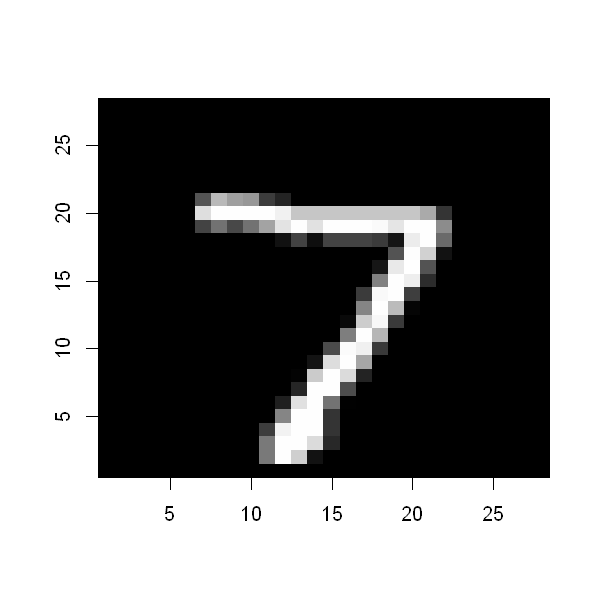

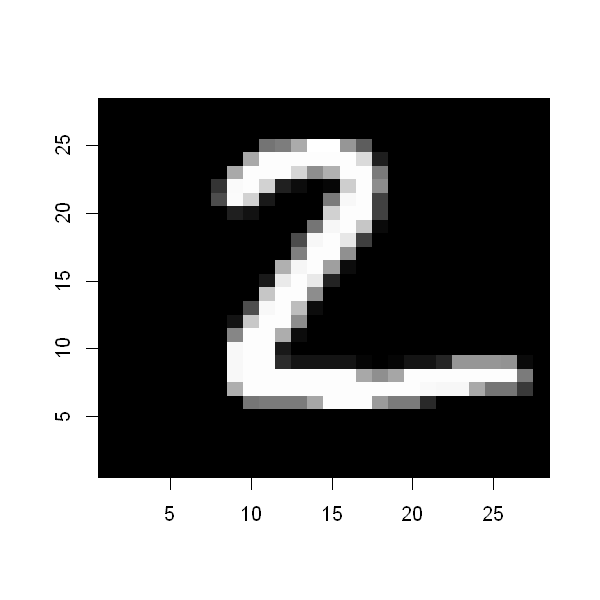

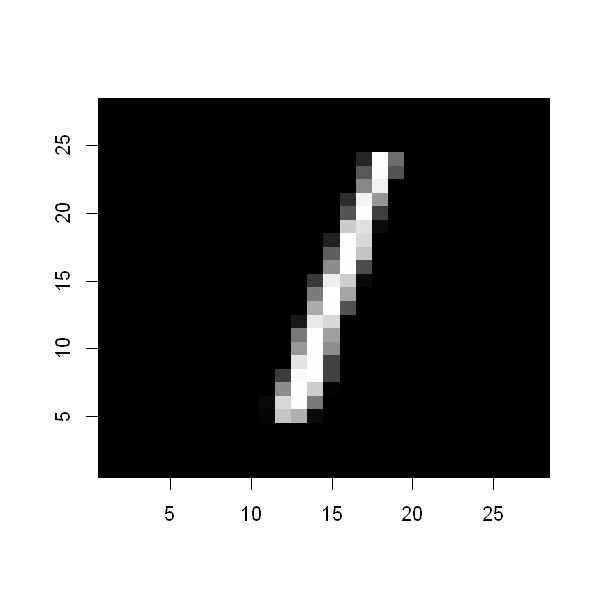

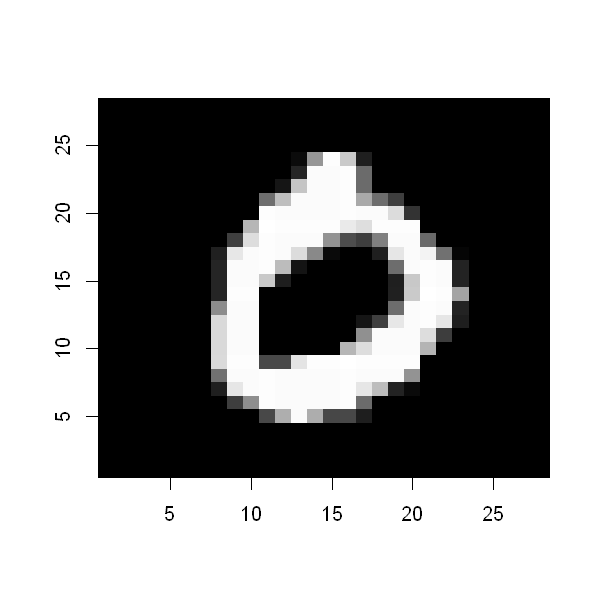

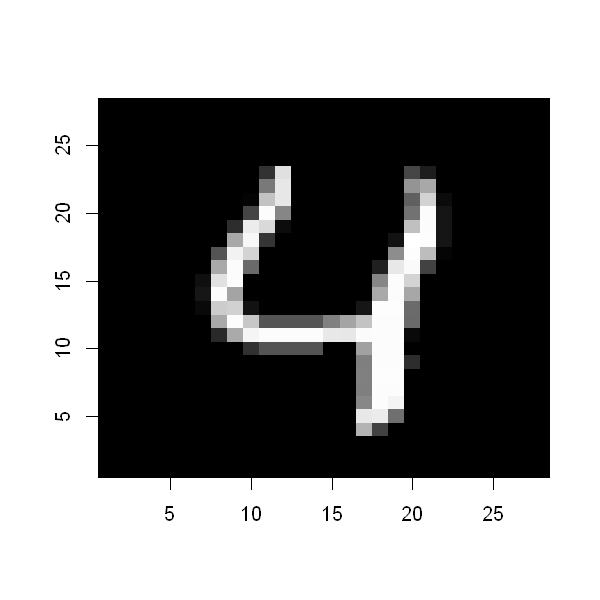

In [15]:
# forecast first 5 test set examples
probability_model <- keras_model_sequential() %>%
  mnist_ffnn_model() %>%
  keras::layer_activation_softmax() %>%
  keras::layer_lambda(keras::k_argmax)
probability_model(mnist_x_test[1:5, , ])

options(repr.plot.width = 5, repr.plot.height = 5)
for (i in 1:5) {
    image(1:28, 1:28, mnist_x_test[i, , ]  %>% apply(2, rev) %>% t(), col = gray((0:255) / 255), xlab = "", ylab = "")
}
options(repr.plot.width = 20, repr.plot.height = 8)

## 5. Feed-forward neural network: Regression (Richman & Wüthrich 2021)
code adapted from https://github.com/DeutscheAktuarvereinigung/Mortality_Modeling/blob/master/DAV%20Use%20Case%20Mortality%20Modeling-Final_V3.ipynb

### Configure the network architecture

In [16]:
# DEEP5 model from Richman & Wüthrich 2021
Year <- keras::layer_input(shape = c(1), dtype = "float32", name = "Year")
Age <- keras::layer_input(shape = c(1), dtype = "int32", name = "Age")
Country <- keras::layer_input(shape = c(1), dtype = "int32", name = "Country")
Sex <- keras::layer_input(shape = c(1), dtype = "int32", name = "Sex")

# set up the embedding layers
Age_embed <- Age %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Age), 
                         output_dim = 5, input_length = 1, name = "Age_embed") %>% 
  keras::layer_flatten()

Sex_embed <- Sex %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Sex), 
                         output_dim = 5, input_length = 1, name = "Sex_embed") %>%  
  keras::layer_flatten()

Country_embed <- Country %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Country), 
                         output_dim = 5, input_length = 1, name = "Country_embed") %>% 
  keras::layer_flatten()

# concatenate all the feature vectors 
features <- keras::layer_concatenate(list(Year, Age_embed, Sex_embed, Country_embed))

# set up the hidden layers
middle <- features %>%     
  keras::layer_dense(units = 128, activation = "relu") %>% 
  keras::layer_batch_normalization() %>% 
  keras::layer_dropout(0.05) %>% 
    
  keras::layer_dense(units = 128, activation = "relu") %>% 
  keras::layer_batch_normalization() %>% 
  keras::layer_dropout(0.05) %>%  
   
  keras::layer_dense(units = 128, activation = "relu") %>% 
  keras::layer_batch_normalization() %>% 
  keras::layer_dropout(0.05) %>%    
  
  keras::layer_dense(units = 128, activation = "relu") %>% 
  keras::layer_batch_normalization() %>% 
  keras::layer_dropout(0.05)     
      
# set up the output layer
intermediate_ffnn <- keras::layer_concatenate(list(features, middle)) %>% # skip connection
  keras::layer_dense(units = 128, activation = "relu") %>%
  keras::layer_batch_normalization() %>% 
  keras::layer_dropout(0.05) 

output_ffnn <- intermediate_ffnn %>% 
  keras::layer_dense(units = 1, activation = "sigmoid", name = "main_output") 

# set up the model, combining input layers and output layer
model_ffnn <- keras::keras_model(inputs = c(Year, Age, Country, Sex), outputs = c(output_ffnn))

summary(model_ffnn)

Model: "model"
________________________________________________________________________________
 Layer (type)         Output Shape   Param #  Connected to           Trainable  
 Age (InputLayer)     [(None, 1)]    0        []                     Y          
 Sex (InputLayer)     [(None, 1)]    0        []                     Y          
 Country (InputLayer)  [(None, 1)]   0        []                     Y          
 Age_embed (Embedding  (None, 1, 5)  505      ['Age[0][0]']          Y          
 )                                                                              
 Sex_embed (Embedding  (None, 1, 5)  10       ['Sex[0][0]']          Y          
 )                                                                              
 Country_embed (Embed  (None, 1, 5)  190      ['Country[0][0]']      Y          
 ding)                                                                          
 Year (InputLayer)    [(None, 1)]    0        []                     Y          
 flatten_1 (F

### Prepare the features

In [17]:
# convert categorical variables to 0-based integers (needed later for neural nets)
df_train_numeric <- df_train %>%
  dplyr::mutate(dplyr::across(c("Country", "Age", "Sex"), function(x) as.integer(as.factor(x)) - 1)) 

df_map <- cbind(df_train %>% dplyr::mutate(key = paste(Country, Age, Sex)) %>% select(key), 
                df_train_numeric %>% dplyr::select(Country, Age, Sex)) %>% unique()
                            
df_test_numeric <- df_test %>%
  dplyr::mutate(key = paste(Country, Age, Sex)) %>% 
  dplyr::select(-dplyr::one_of(c("Country", "Age", "Sex"))) %>%
  dplyr::left_join(df_map, by = c("key")) %>%
  dplyr::select(-key)
                              
head(df_train_numeric)

# convert input into arrays
ffnn_x_train <- df_train_numeric %>% 
  dplyr::select(Year, Age, Country, Sex, Ex, Dx)
ffnn_x_train_mat <- list(as.matrix(ffnn_x_train$Year), 
                         as.matrix(ffnn_x_train$Age),
                         as.matrix(ffnn_x_train$Country),
                         as.matrix(ffnn_x_train$Sex))

ffnn_x_test <- df_test_numeric %>% 
  dplyr::select(Year, Age, Country, Sex, Ex, Dx)
ffnn_x_test_mat <- list(as.matrix(ffnn_x_test$Year), 
                        as.matrix(ffnn_x_test$Age),
                        as.matrix(ffnn_x_test$Country),
                        as.matrix(ffnn_x_test$Sex))

# prepare the output and convert it into an array
ffnn_y_train <- df_train$mx
ffnn_y_train_mat <- as.matrix(ffnn_y_train)

,Country,Year,Age,Sex,mx,Dx,Ex,log_mx
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1950,0,0,0.022343,2004.35,89707.97,-3.801242
2,0,1950,0,1,0.028362,2662.40,93871.95,-3.562705
3,0,1950,1,0,0.002739,238.04,86892.88,-5.900162
4,0,1950,1,1,0.003026,275.14,90918.15,-5.800514
5,0,1950,2,0,0.001019,90.02,88341.23,-6.888934
6,0,1950,2,1,0.001814,168.09,92640.39,-6.312221


### Train the model (can take a few hours) and predict

In [18]:
model_ffnn %>%
    keras::compile(optimizer = "adam", loss = "mse") 

if (USE_TRAINED_MODELS && file.exists("models/ffnn.h5")) {
    model_ffnn <- keras::load_model_hdf5("models/ffnn.h5")
} else {
    # fit
    model_ffnn %>%
        fit(x = ffnn_x_train_mat, y = ffnn_y_train_mat, epochs = 300) 

    keras::save_model_hdf5(model_ffnn, "models/ffnn.h5")
}

ffnn_prediction <- df_test %>%
  dplyr::mutate(mx_prediction = model_ffnn %>% predict(ffnn_x_test_mat))

### FFNN forecasts and error measures

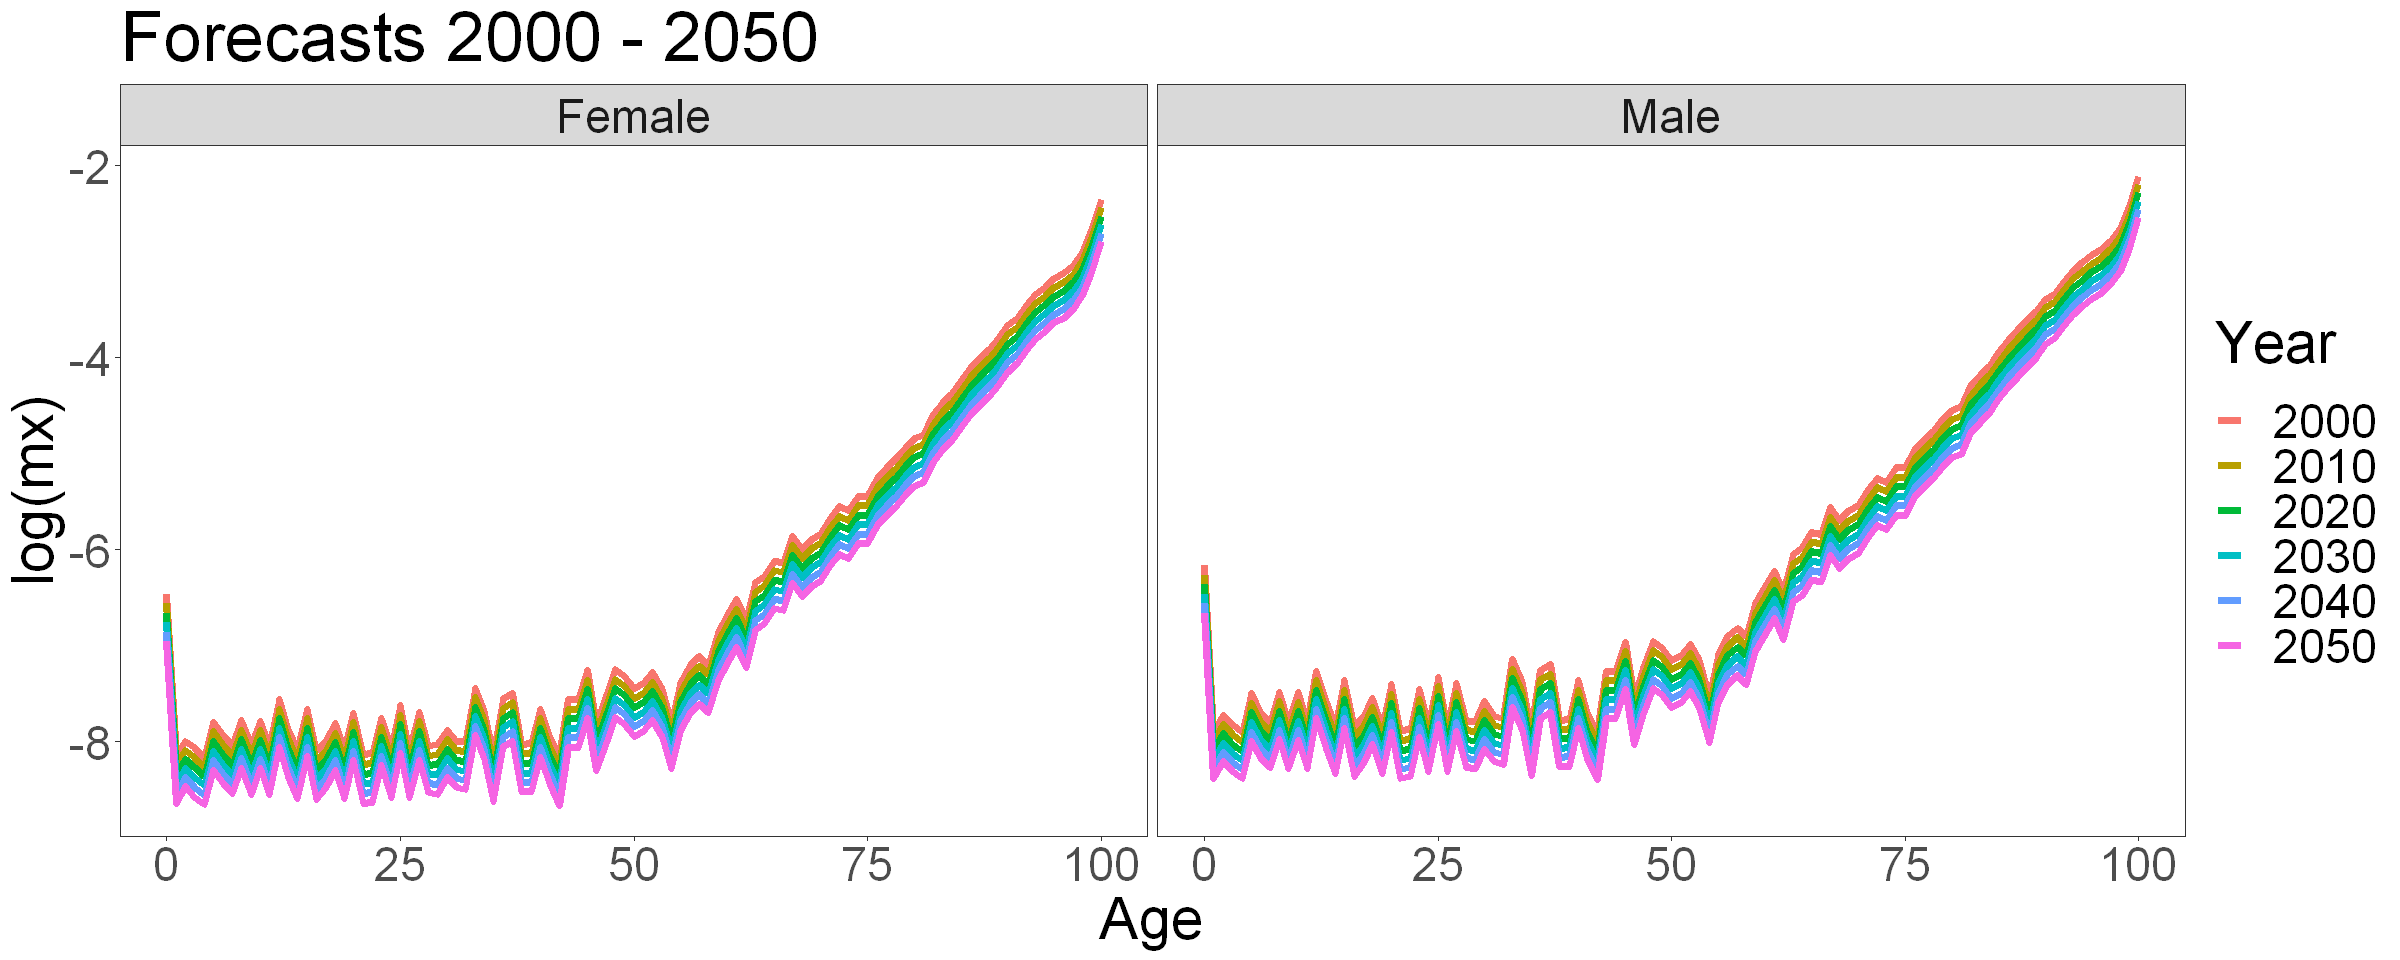

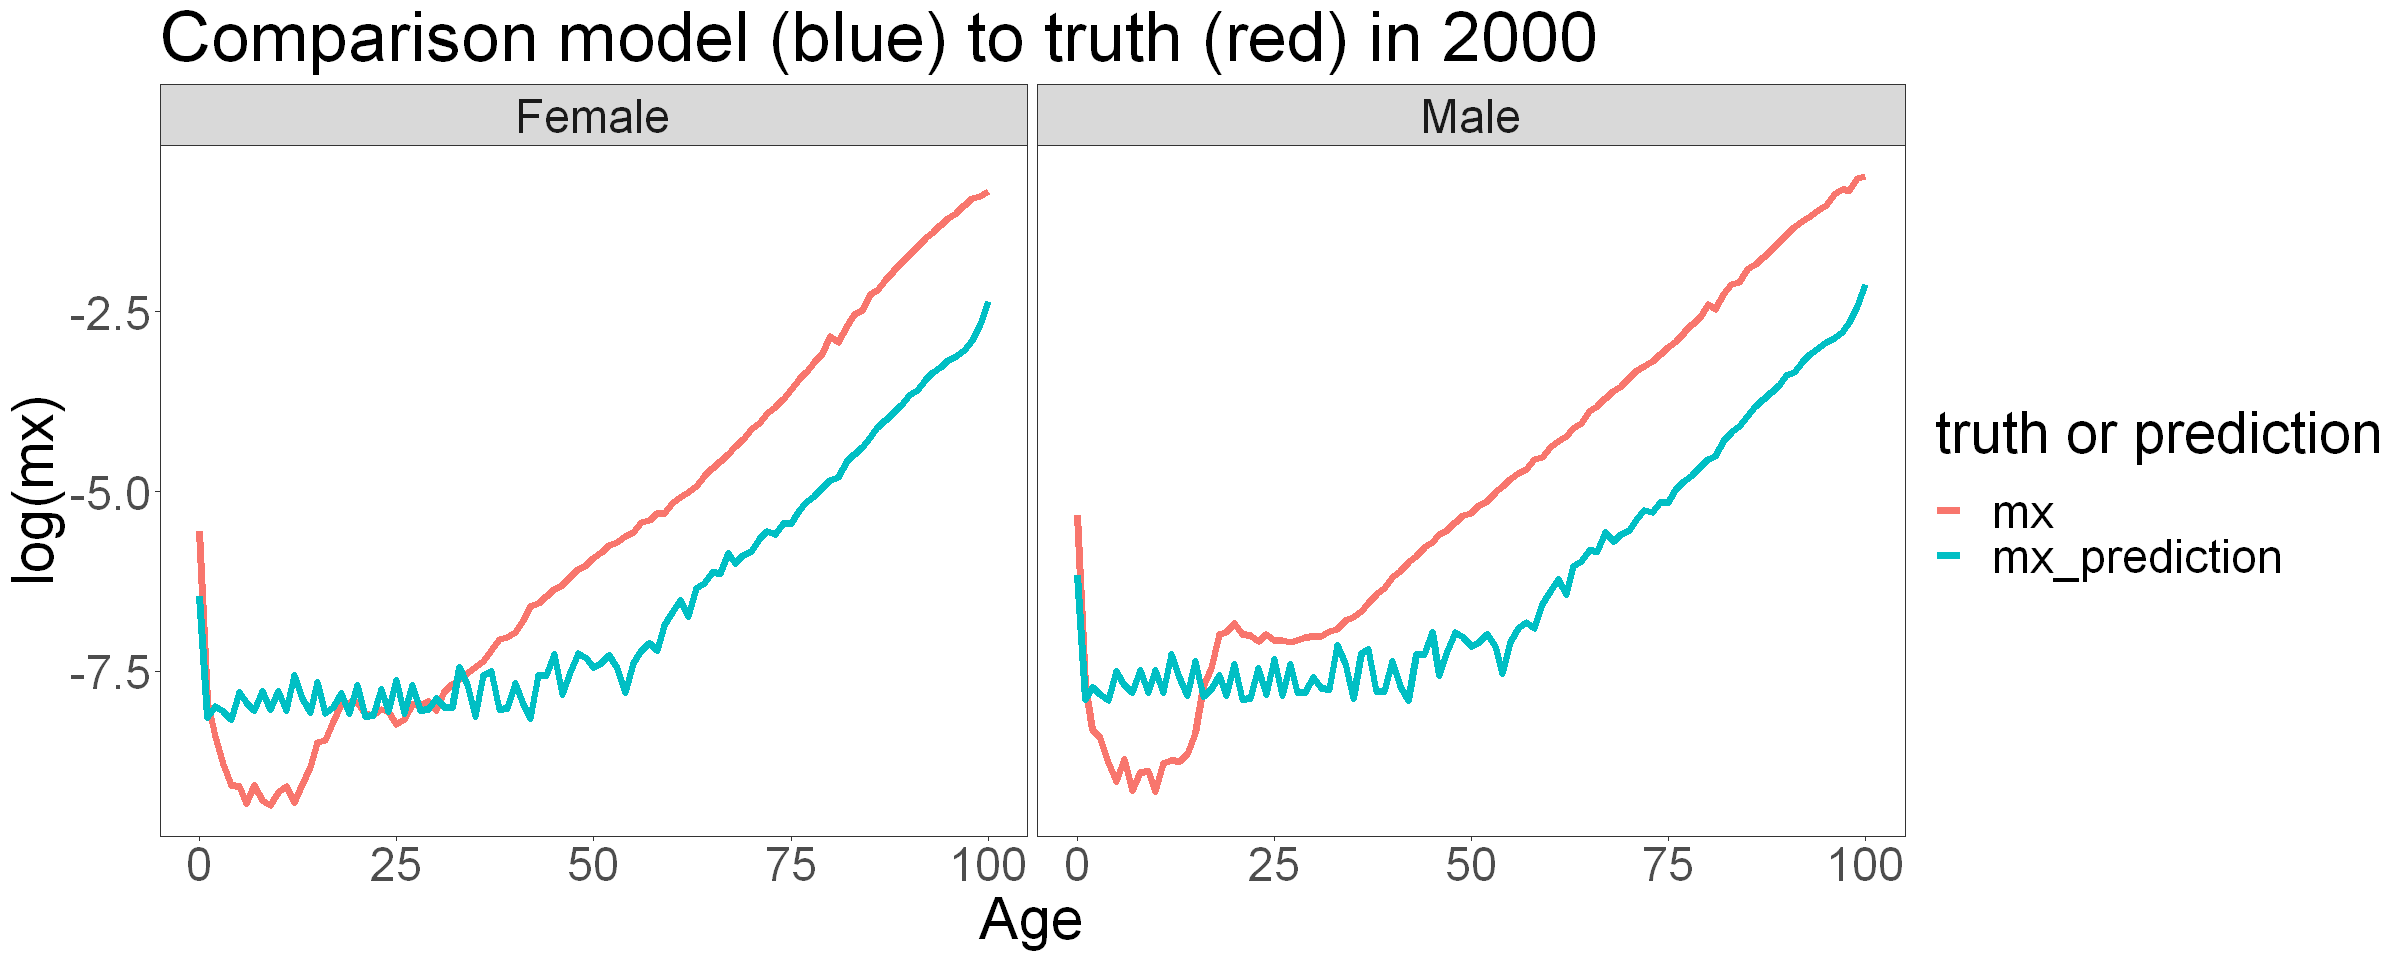

[1] "Total error measures"


MSE,MAPE
<dbl>,<dbl>
0.010803,0.937


[1] "Error measures by country-sex group"


Country,Sex,MSE,MAPE
<chr>,<chr>,<dbl>,<dbl>
CHL,Female,0.006574,0.7162
TWN,Female,0.006577,0.7697
ISL,Female,0.008650,0.7738
ISL,Male,0.012882,0.7854
BGR,Female,0.015918,0.8007
UKR,Female,0.015525,0.8068
EST,Female,0.009928,0.8084
CHL,Male,0.009852,0.8089
RUS,Female,0.014083,0.8160


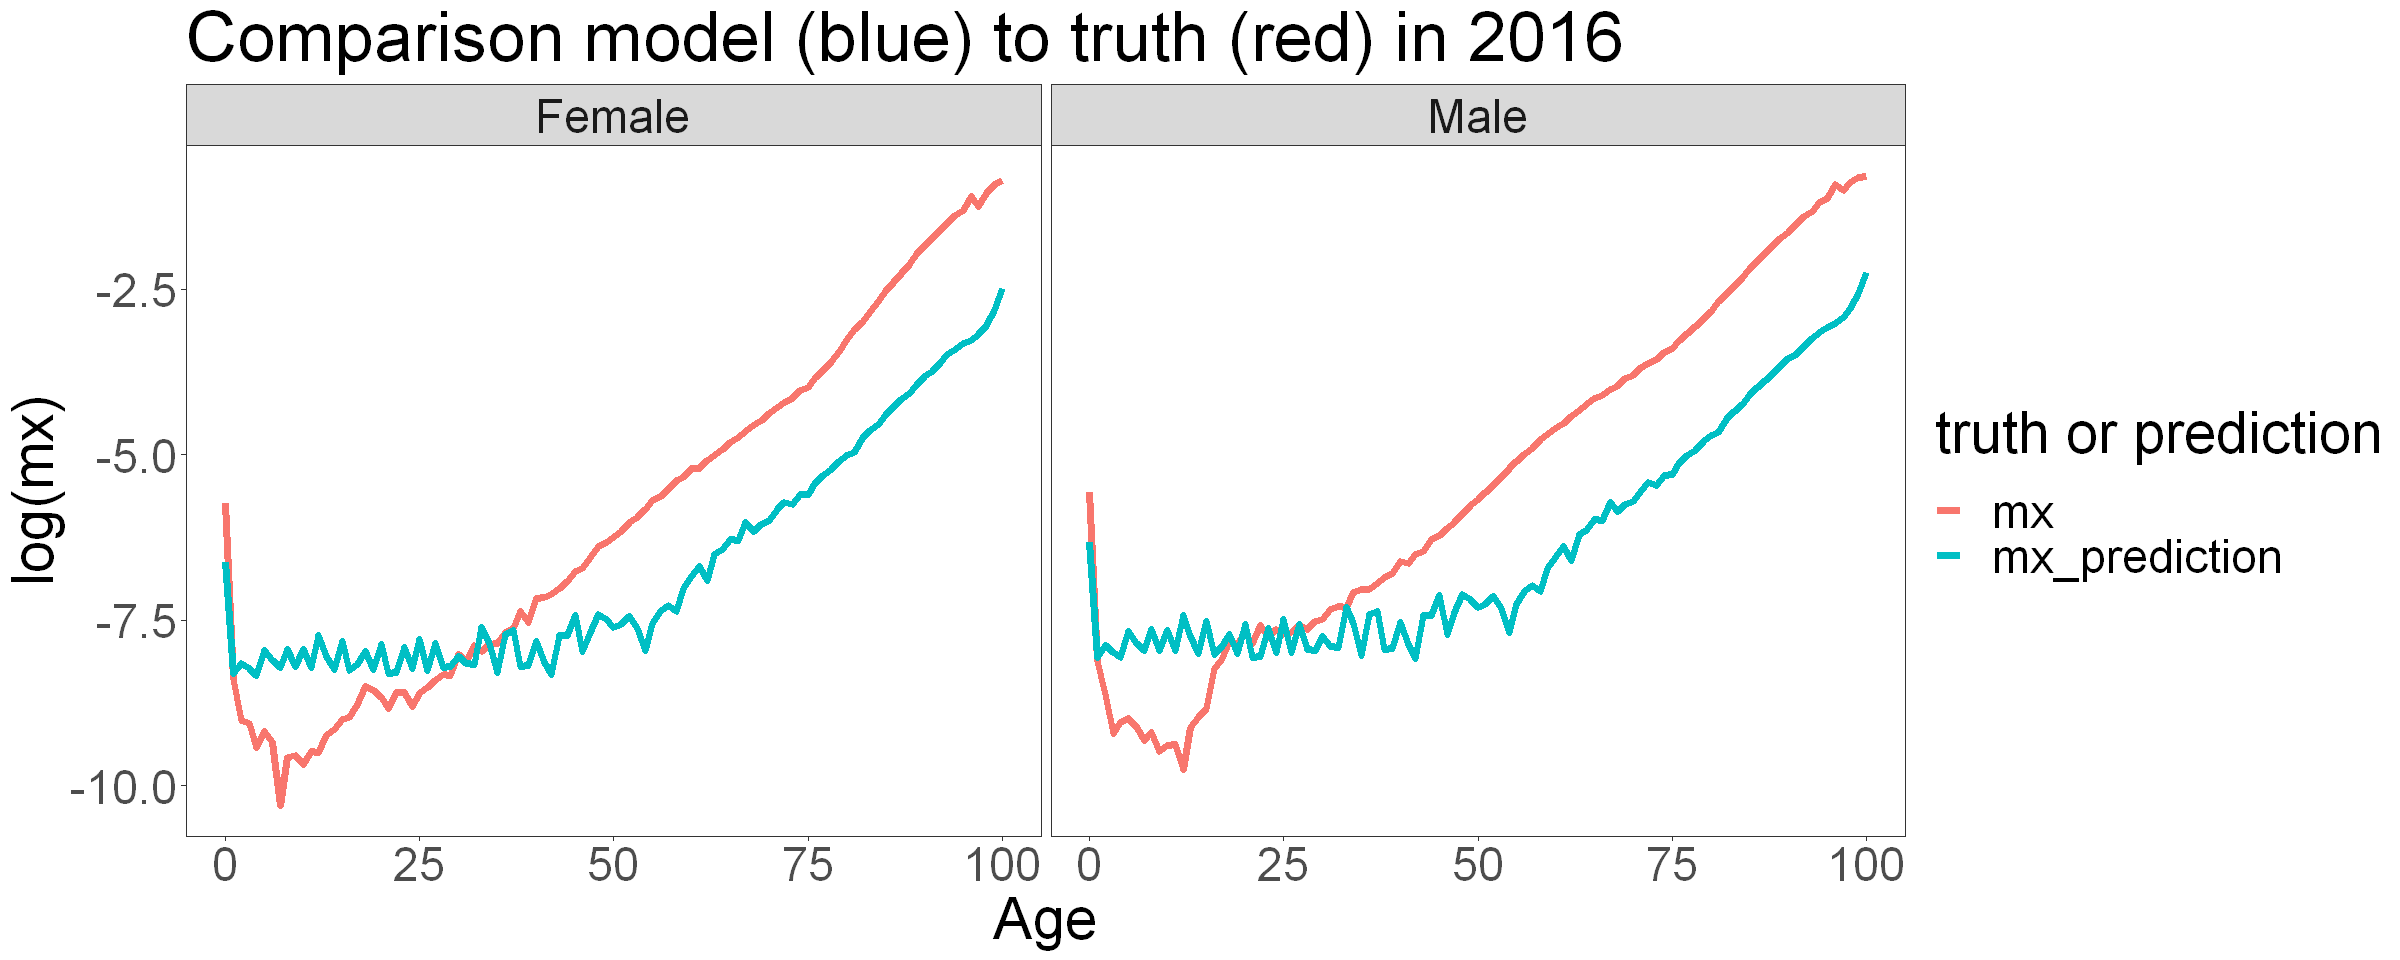

In [19]:
# forecasts look problematic
# approaches for improvement include hyperparameter tuning and ensembles
plot_all_forecasts(ffnn_prediction, country = "DEUTNP", years = seq(2000, 2050, by = 10))
plot_comparison_for_year(ffnn_prediction, country = "DEUTNP", year = 2000)
plot_comparison_for_year(ffnn_prediction, country = "DEUTNP", year = 2016)

print("Total error measures")
ffnn_errors_total <- calculate_error_measures(ffnn_prediction, groups = NULL)
ffnn_errors_total

print("Error measures by country-sex group") 
ffnn_errors_grouped <- calculate_error_measures(ffnn_prediction, groups = c("Country", "Sex")) %>%
  dplyr::arrange(MAPE)
ffnn_errors_grouped

## 6. Recurrent neural network: Integration into Lee-Carter model (Nigri et al. 2019)

### Prepare data

In [20]:
# originally, Nigri et al. 2019 train one LSTM per population. They follow a rolling window approach to acquire some training data.
# Here, we also use this rolling window approach, but we train one LSTM for all the populations, using country and sex as (embedded) features.

# generate training data
lstm_train <- lapply(names(lc_models), 
                     function(name) cbind(
                         data.frame(Country = gsub("-.*", "", name) , Sex = gsub(".*-", "", name)),
                         zoo::rollapply(lc_models[[name]]$kt, 
                                        width = LSTM_LOOKBACK_LENGTH + 1, # following Nigri et al. 2019, lookback length would be 1. We use 3.
                                        FUN = function(kt) matrix(kt, ncol = LSTM_LOOKBACK_LENGTH + 1)))) %>%
  data.table::rbindlist()
                                        
# join integers for Country and Sex
df_map <- cbind(df_train %>% dplyr::mutate(key = paste(Country, Sex)) %>% select(key), 
                df_train_numeric %>% dplyr::select(Country, Sex)) %>% unique()               
lstm_train <- lstm_train %>%
  as.data.frame() %>%
  dplyr::mutate(key = paste(Country, Sex)) %>%
  dplyr::select(-dplyr::one_of(c("Country", "Sex"))) %>%
  dplyr::left_join(df_map, by = "key") %>%
  dplyr::select(-key)
                                    
head(lstm_train)

,1,2,3,4,Country,Sex
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,46.44540,46.16122,43.05750,37.23437,0,0
2,46.16122,43.05750,37.23437,35.30396,0,0
3,43.05750,37.23437,35.30396,30.86555,0,0
4,37.23437,35.30396,30.86555,30.06142,0,0
5,35.30396,30.86555,30.06142,28.26464,0,0
6,30.86555,30.06142,28.26464,23.36946,0,0


In [21]:
# time series input
lstm_train_ts <- lstm_train %>%
  dplyr::select(-dplyr::one_of(c("Country", "Sex")))
lstm_x_train <- lstm_train_ts[, seq_len(ncol(lstm_train_ts) - 1), drop = FALSE]
lstm_y_train <- lstm_train_ts[, ncol(lstm_train_ts), drop = FALSE]
        
# all the inputs as a list
lstm_x_train_mat <- list(array(lstm_x_train %>% simplify2array, dim = c(nrow(lstm_x_train), LSTM_LOOKBACK_LENGTH, 1)), # Keras LSTM input must be a 3D array (n_samples, n_lookback, 1)
                         as.matrix(lstm_train$Country),
                         as.matrix(lstm_train$Sex))

lstm_y_train_mat <- as.matrix(lstm_y_train)
                                        
# generate testing data (= time series observation in the last training year)
lstm_test <- lstm_train %>%
  dplyr::group_by(Country, Sex) %>%
  dplyr::filter(dplyr::row_number() == dplyr::n()) # select only last row (= last year) per group
                                        
lstm_x_test <- lstm_test %>%
  dplyr::ungroup() %>%
  dplyr::select(-dplyr::one_of(c("Country", "Sex")))
lstm_x_test <- lstm_x_test[, seq_len(ncol(lstm_x_test) - 1) + 1, drop = FALSE]
lstm_x_test_mat <- list(array(lstm_x_test %>% simplify2array, dim = c(nrow(lstm_x_test), LSTM_LOOKBACK_LENGTH, 1)), 
                        as.matrix(lstm_test$Country),
                        as.matrix(lstm_test$Sex))

### Config model

In [22]:
LSTM <- MortalitySeries <- keras::layer_input(shape = c(LSTM_LOOKBACK_LENGTH, 1), dtype = "float32", name = "MortalitySeries")
  
Sex <- keras::layer_input(shape = c(1), dtype = "int32", name = "Sex")
Country <- keras::layer_input(shape = c(1), dtype = "int32", name = "Country")

# embeddings
Sex_embed <- Sex %>%
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Sex), output_dim = 5, input_length = 1, name = "Sex_embed") %>%
  keras::layer_flatten()
Country_embed <- Country %>%
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Country), output_dim = 5, input_length = 1, name = "Country_embed") %>%
  keras::layer_flatten()
    
features <- c(list(Sex_embed), list(Country_embed))
  
# LSTM
LSTM <- LSTM %>% 
  keras::layer_lstm(units = 50, 
                    activation = "relu")
  
# output layer
output <- c(list(LSTM), features) %>% 
  keras::layer_concatenate() %>%
  keras::layer_dense(units = 1, activation = "linear")
  
# set up model
model_lstm <- keras::keras_model(inputs = c(list(MortalitySeries), list(Country), list(Sex)), outputs = output)

### Fit and forecast

In [23]:
# compile
model_lstm %>% 
  keras::compile(optimizer = "adam", loss = "mse")

if (USE_TRAINED_MODELS && file.exists("models/lstm.h5")) {
    model_lstm <- keras::load_model_hdf5("models/lstm.h5")
} else {
    # fit
    model_lstm %>%
      fit(x = lstm_x_train_mat, y = lstm_y_train_mat, epochs = 100)

    keras::save_model_hdf5(model_lstm, "models/lstm.h5")
}

# predict
lstm_prediction <- data.frame()
lstm_x_test_mat_year <- lstm_x_test_mat

# loop over years (n-step forecasts = recursive 1-step forecasts)
for (year in sort(unique(df_test$Year))) {
  df_test_year <- df_test %>%
    dplyr::filter(Year == year) %>%
    dplyr::select(Country, Year, Age, Sex)
    
  kt_prediction <- model_lstm %>% predict(lstm_x_test_mat_year)
  names(kt_prediction) <- df_test %>%
    dplyr::select(Country, Sex) %>% 
    unique() %>%
    dplyr::mutate(Name = paste(Country, Sex, sep = "-")) %>%
    pull(Name)
    
  prediction_year <- df_test_year %>%
    dplyr::group_by(Country, Sex) %>%
    # LC prediction based on LSTM period effect forecast
    dplyr::mutate(mx_prediction = lc_models[[paste(unique(Country), unique(Sex), sep = "-")]] %>% 
                  forecast_LC_based_on_kt(kt_prediction[[paste(unique(Country), unique(Sex), sep = "-")]]))
    
  # update LSTM input for next year
  if (LSTM_LOOKBACK_LENGTH > 1) {
    lstm_x_test_mat_year[[1]][, seq_len(LSTM_LOOKBACK_LENGTH - 1), 1] <- lstm_x_test_mat_year[[1]][, 2:LSTM_LOOKBACK_LENGTH, 1] 
  }
  lstm_x_test_mat_year[[1]][, LSTM_LOOKBACK_LENGTH, 1] <- kt_prediction
    
  # add current year predictions to lstm_prediction
  lstm_prediction <- lstm_prediction %>%
    bind_rows(prediction_year)
}

lstm_prediction <- lstm_prediction %>% 
  dplyr::left_join(df_test, by = c("Age", "Year", "Country", "Sex"))

### LSTM forecasts and error measures

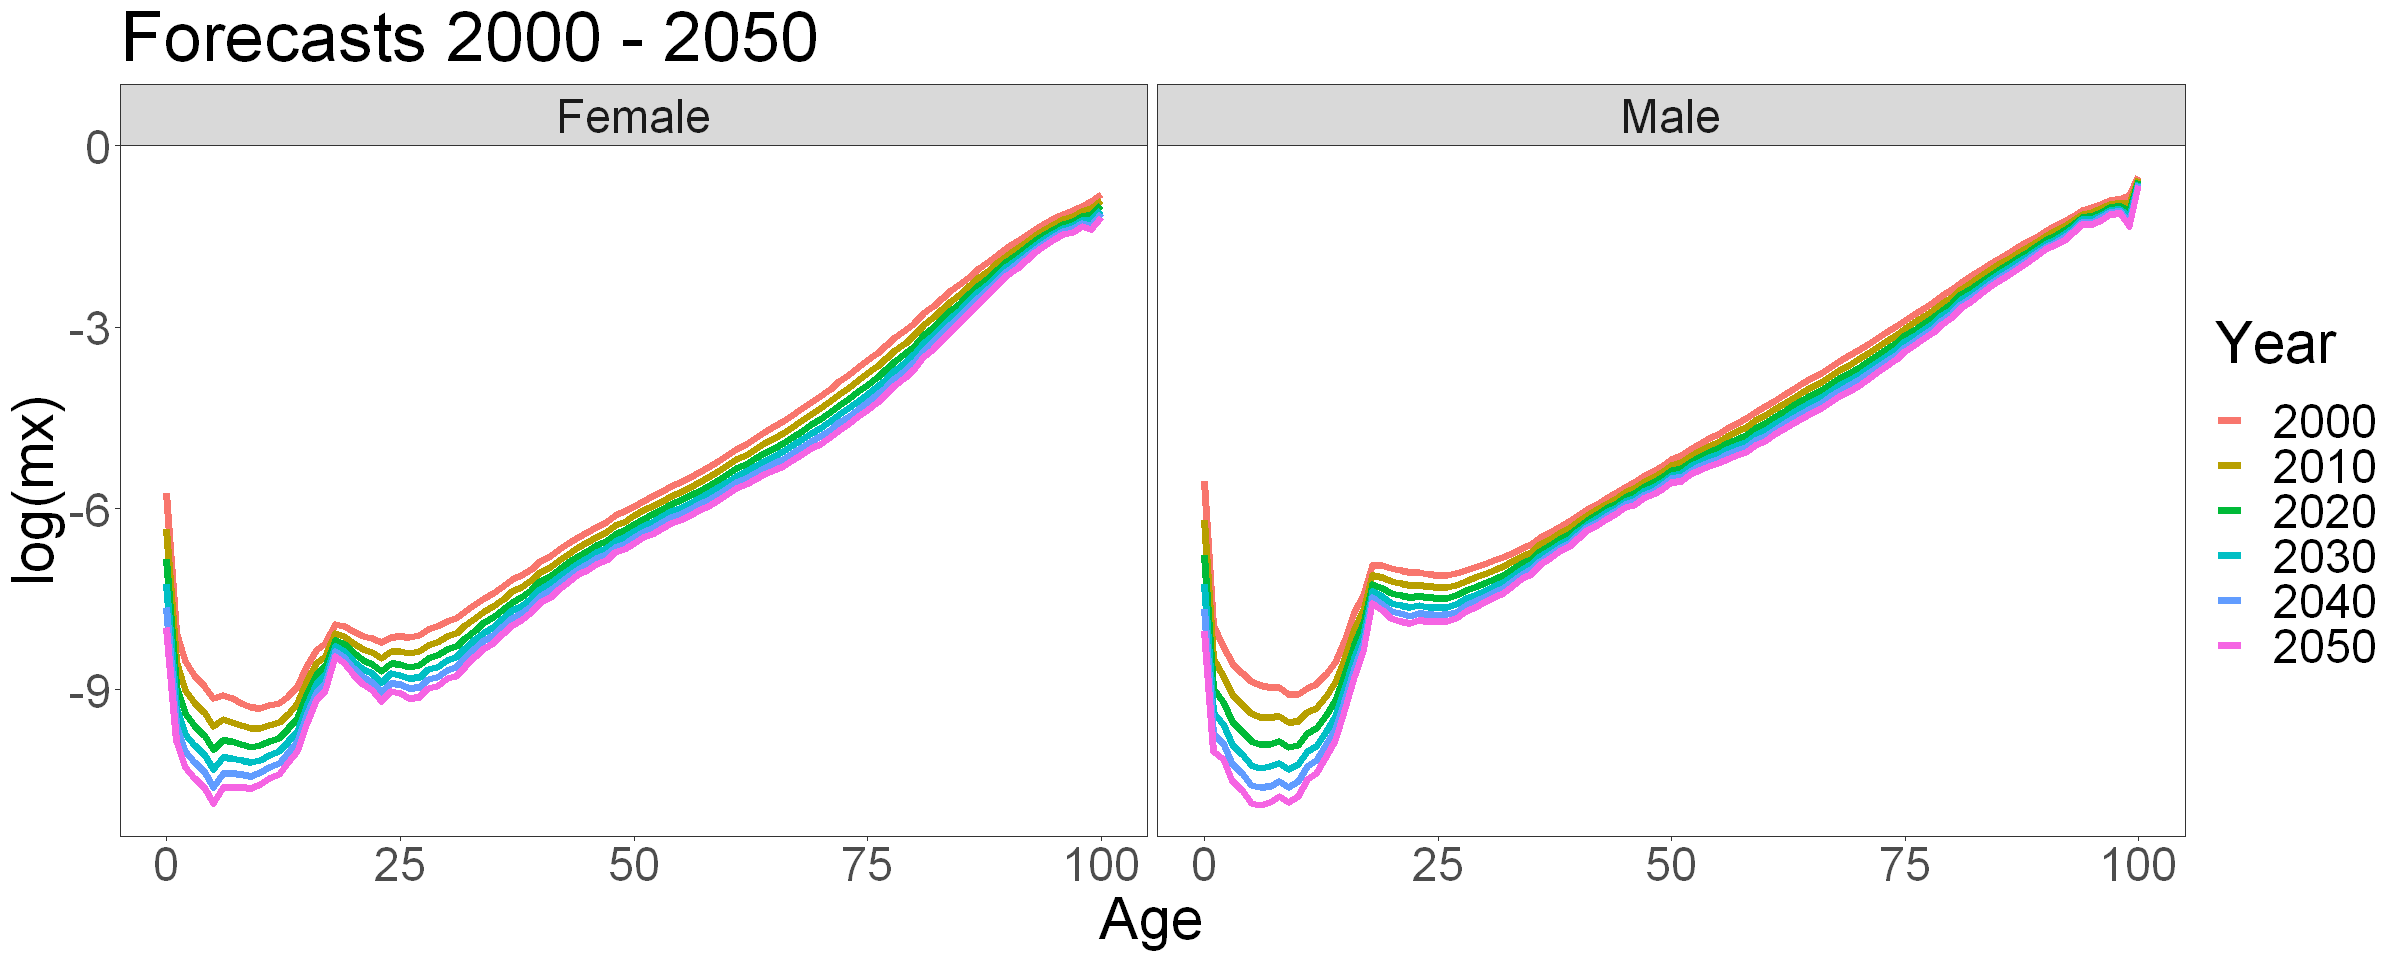

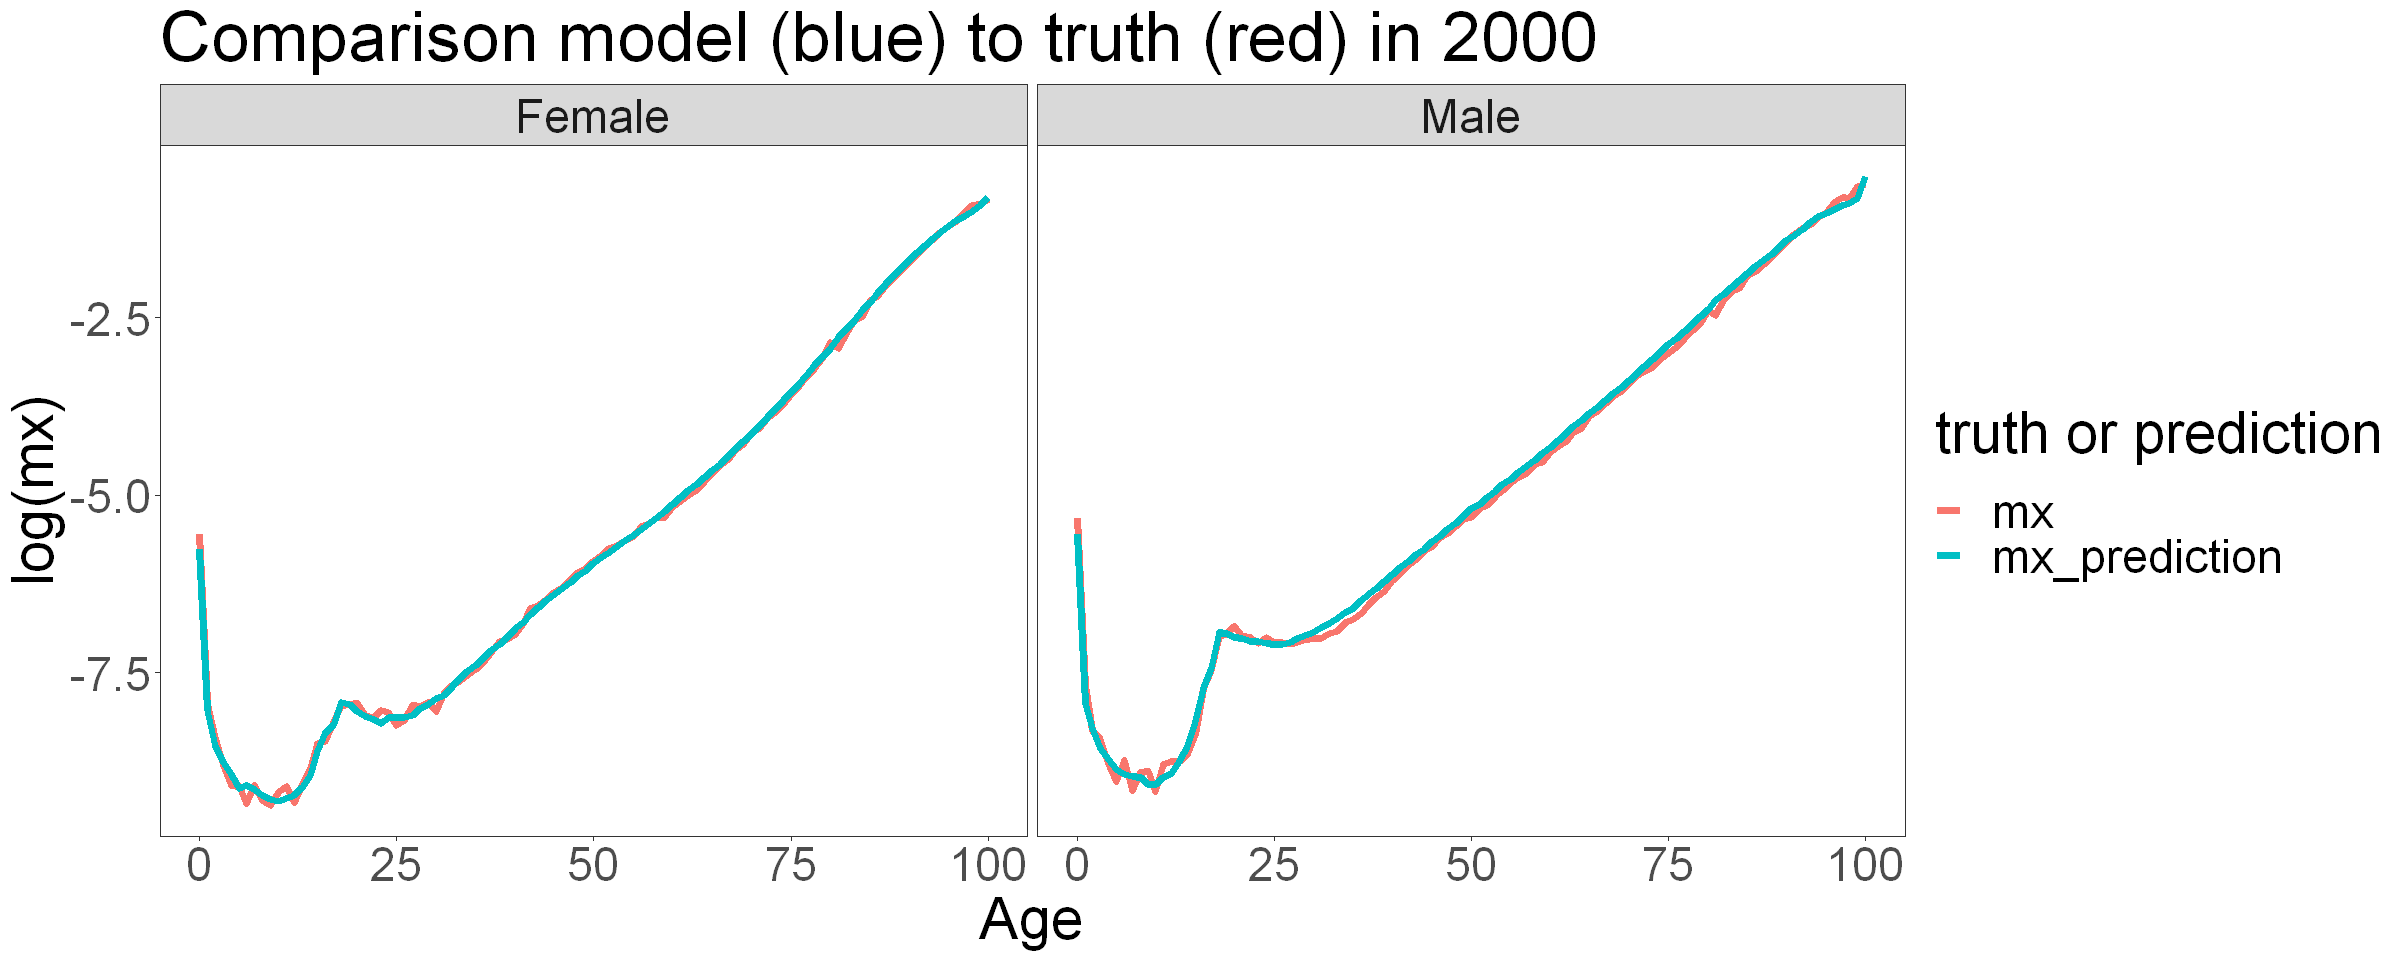

[1] "Total error measures"


MSE,MAPE
<dbl>,<dbl>
4.025027e+59,3.180503e+30


[1] "Error measures by country-sex group"


Country,Sex,MSE,MAPE
<chr>,<chr>,<dbl>,<dbl>
DEUTNP,Female,0.000110,0.1036
CAN,Female,0.000102,0.1170
ITA,Female,0.000040,0.1180
USA,Male,0.000067,0.1230
GBRTENW,Female,0.000048,0.1356
USA,Female,0.000108,0.1457
FRATNP,Female,0.000053,0.1491
JPN,Male,0.000162,0.1552
AUS,Female,0.000164,0.1563


[1] "Total error measures without UKR_F"


MSE,MAPE
<dbl>,<dbl>
0.003351,0.3356


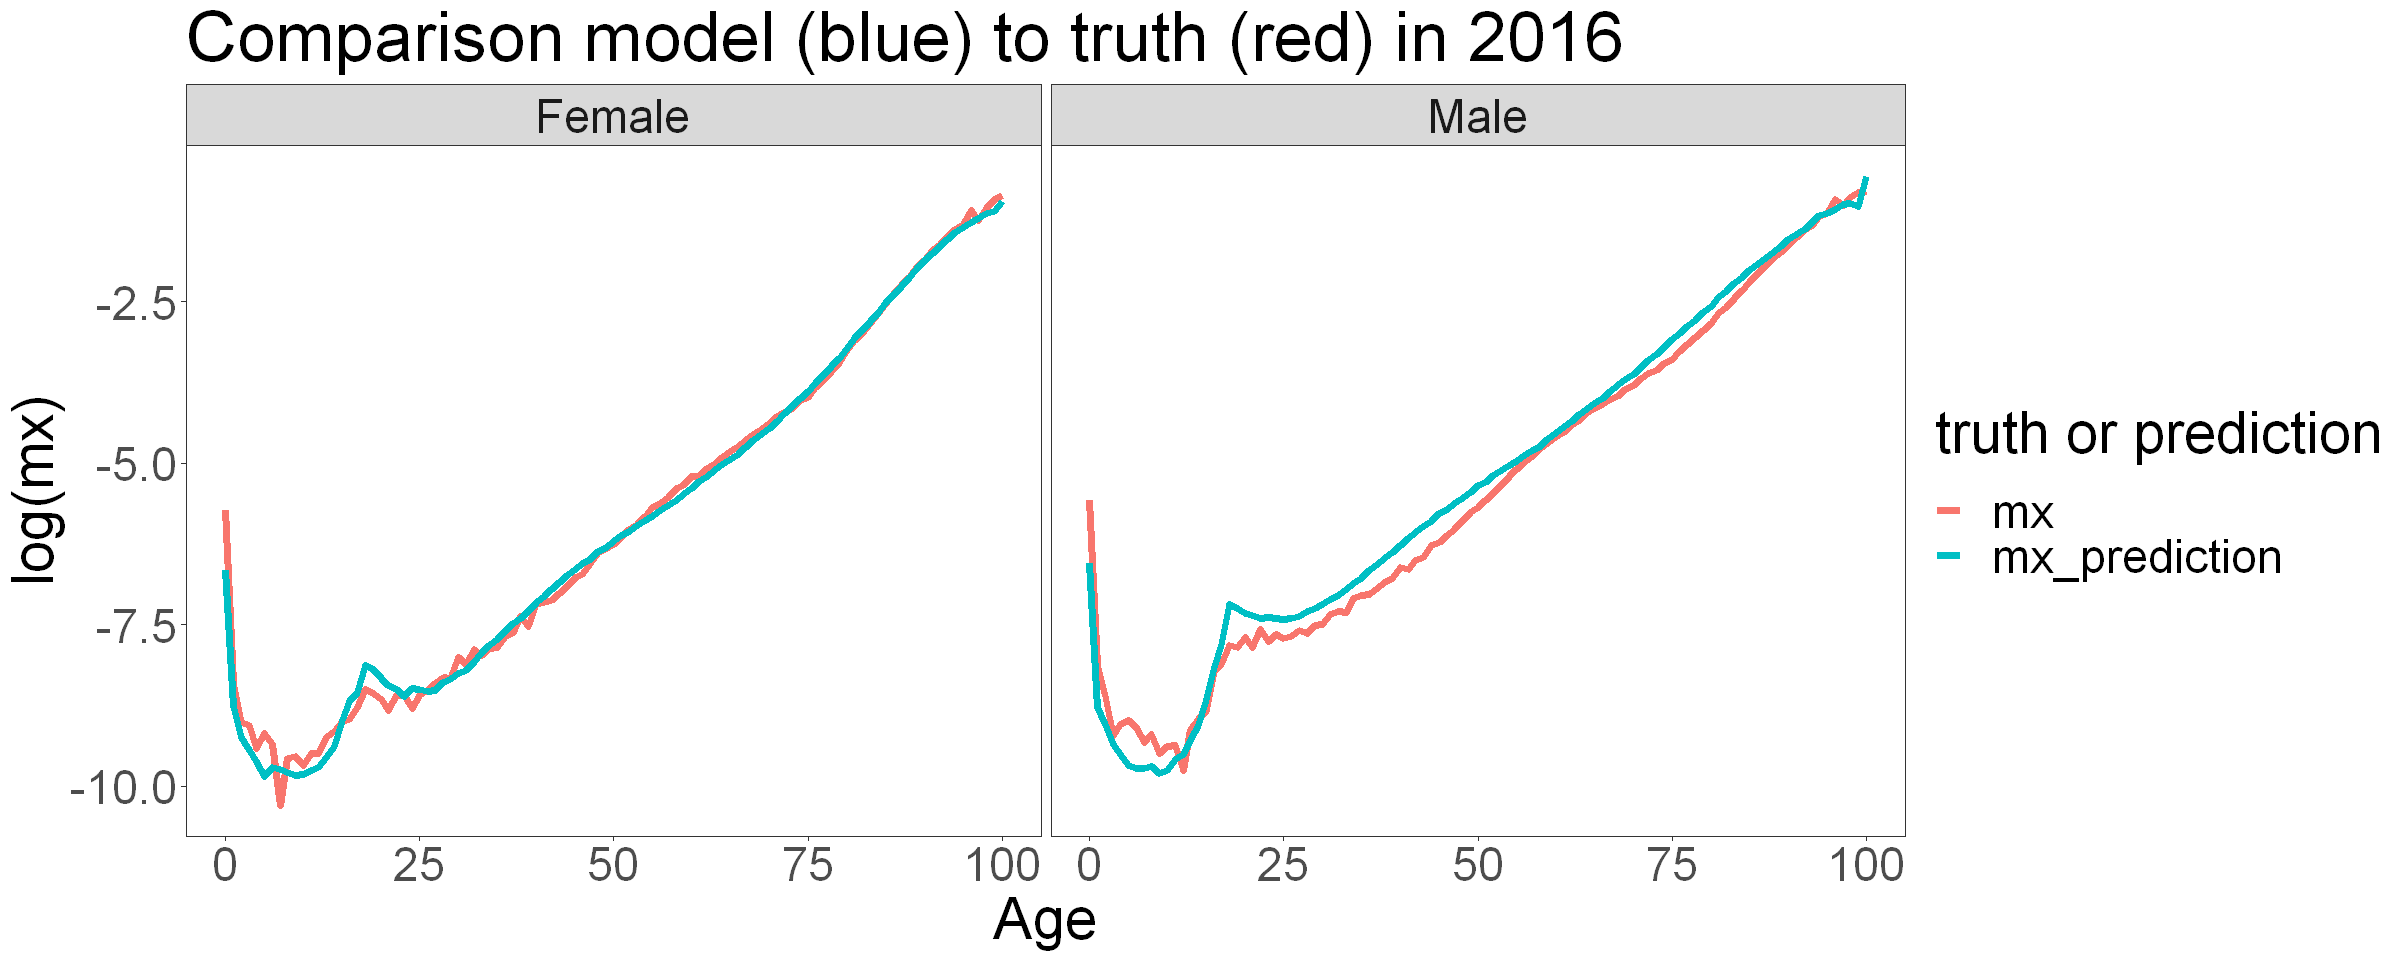

In [24]:
plot_all_forecasts(lstm_prediction, country = "DEUTNP", years = seq(2000, 2050, by = 10))
plot_comparison_for_year(lstm_prediction, country = "DEUTNP", year = 2000)
plot_comparison_for_year(lstm_prediction, country = "DEUTNP", year = 2016)

print("Total error measures")
lstm_errors_total <- calculate_error_measures(lstm_prediction, groups = NULL)
lstm_errors_total

print("Error measures by country-sex group")
lstm_errors_grouped <- calculate_error_measures(lstm_prediction, groups = c("Country", "Sex")) %>% 
  dplyr::arrange(MAPE)
lstm_errors_grouped

print("Total error measures without UKR_F")
lstm_errors_total_UKR <- calculate_error_measures(lstm_prediction %>% dplyr::filter(paste(Country, Sex) != "UKR Female"), groups = NULL)
lstm_errors_total_UKR

## 7. Convolutional neural network for MNIST 
code adapted from https://github.com/rstudio/keras/blob/main/vignettes/examples/mnist_cnn.R

In [25]:
# redefine dimension of train/test inputs
mnist_x_train_cnn <- keras::array_reshape(mnist_x_train, c(nrow(mnist_x_train), 28, 28, 1)) # 28x28 images
mnist_x_test_cnn <- keras::array_reshape(mnist_x_test, c(nrow(mnist_x_test), 28, 28, 1))
input_shape <- c(28, 28, 1)

# convert class vectors to binary class matrices
mnist_y_train_cnn <- keras::to_categorical(mnist_y_train, num_classes = 10)
mnist_y_test_cnn <- keras::to_categorical(mnist_y_test, num_classes = 10)

# define model
model_mnist_cnn <- keras::keras_model_sequential() %>%
  keras::layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = 'relu',
                input_shape = input_shape) %>% 
  keras::layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = 'relu') %>% 
  keras::layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  keras::layer_dropout(rate = 0.25) %>% 
  keras::layer_flatten() %>% 
  keras::layer_dense(units = 128, activation = 'relu') %>% 
  keras::layer_dropout(rate = 0.5) %>% 
  keras::layer_dense(units = 10, activation = 'softmax')

# compile model
model_mnist_cnn %>% keras::compile(
  loss = keras::loss_categorical_crossentropy,
  optimizer = keras::optimizer_adadelta(),
  metrics = c('accuracy')
)

if (USE_TRAINED_MODELS && file.exists("models/cnn_mnist.h5")) {
    model_mnist_cnn <- keras::load_model_hdf5("models/cnn_mnist.h5")
} else {
    # train model
    model_mnist_cnn %>% fit(
      mnist_x_train_cnn, mnist_y_train_cnn,
      batch_size = 256,
      epochs = 5
    )

    keras::save_model_hdf5(model_mnist_cnn, "models/cnn_mnist.h5")
}

# evaluate model (accuracy = correct classifications / all classifications)
model_mnist_cnn %>% evaluate(
  mnist_x_test_cnn, mnist_y_test_cnn
) 

loss   accuracy 
0.03626037 0.98850000

## 8. CANN (see Schelldorfer & Wüthrich 2019) for mortality 

### Set up model (treating GLM coefficients as untrainable NN weights)

In [26]:
# fit homogeneous model (needed for weight initialization of the NN)
model_hom <- glm(formula = round(Dx) ~ 1,
                 family = poisson(),
                 data = df_train_glm,
                 offset = log(Ex))
lambda_hom <- model_hom$coefficients %>% unname() %>% exp()

In [27]:
# compare Listing 5 in Schelldorfer & Wüthrich 2019
Year <- keras::layer_input(shape = c(1), dtype = "float32", name = "Year")
Age <- keras::layer_input(shape = c(1), dtype = "int32", name = "Age")
Country <- keras::layer_input(shape = c(1), dtype = "int32", name = "Country")
Sex <- keras::layer_input(shape = c(1), dtype = "int32", name = "Sex")
LogExposureGLM <- keras::layer_input (shape = c(1), dtype = "float32", name = "LogExposureGLM")

# set up the embedding layer of the neural net
Age_embed <- Age %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Age), 
                         output_dim = 5, input_length = 1, name = "Age_embed") %>% 
  keras::layer_flatten()

Sex_embed <- Sex %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Sex), 
                         output_dim = 5, input_length = 1, name = "Sex_embed") %>% 
  keras::layer_flatten()

Country_embed <- Country %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Country), 
                         output_dim = 5, input_length = 1, name = "Country_embed") %>% 
  keras::layer_flatten()

# concatenate all the feature vectors 
features <- keras::layer_concatenate(list(Year, Age_embed, Sex_embed, Country_embed))

# set up the hidden layers
network_cann <- features %>%     
  keras::layer_dense(units = 64, activation = "tanh") %>% 
  keras::layer_batch_normalization() %>% 
  keras::layer_dropout(0.05) %>% 

  keras::layer_dense(units = 32, activation = "tanh") %>%
  keras::layer_batch_normalization() %>% 
  keras::layer_dropout(0.05) %>%
  keras::layer_dense(
      units = 1, activation = "linear", name = "Network",
      kernel_initializer = keras::initializer_glorot_uniform(), # standard initialization
      bias_initializer = keras::initializer_constant(log(lambda_hom)) # initialize network bias to homogeneous intensity
)
                   
# set up the output layer
# ----------------------------------------------
# cf. Eq. (3.6) in Schelldorfer/Wüthrich:
# Deaths ~ Poi(exp(FFNN + GLM) * Exposure) 
#        = Poi(exp(FFNN + GLM + log(Exposure))) 
#        =: Poi(exp(FFNN + LogExposureGLM))
# ----------------------------------------------
output_cann <- list(network_cann, LogExposureGLM) %>%
  keras::layer_add(name = "add") %>%
  keras::layer_dense(units = 1, activation = "exponential", name = "Response", trainable = FALSE,
                     weights = list(array(1, dim = c(1, 1)), array(0, dim = c(1)))) # initialize with unit weight and zero bias to only exponentiate

# set up the model, combining input layers and output layer
model_cann <- keras::keras_model(inputs = c(Year, Age, Country, Sex, LogExposureGLM), outputs = c(output_cann))

### Set up data

In [28]:
# convert categorical variables to 0-based integers 
df_train_glm_numeric <- df_train_glm %>%
  dplyr::mutate(dplyr::across(c("Country", "Age", "Sex"), function(x) as.integer(as.factor(x)) - 1))

df_map <- cbind(df_train_glm %>% dplyr::mutate(key = paste(Country, Age, Sex)) %>% select(key), 
                df_train_glm_numeric %>% dplyr::select(Country, Age, Sex)) %>% unique()
                            
df_test_glm_numeric <- df_test_glm %>%
  dplyr::mutate(key = paste(Country, Age, Sex)) %>%
  dplyr::select(-dplyr::one_of(c("Country", "Age", "Sex"))) %>%
  dplyr::left_join(df_map, by = c("key")) %>%
  dplyr::select(-key)
                              
head(df_train_glm_numeric)

# convert input into arrays
cann_x_train <- df_train_glm_numeric %>% 
  dplyr::select(Year, Age, Country, Sex, Ex, Dx)                              
                              
cann_x_train_mat <- list(as.matrix(cann_x_train$Year), 
                         as.matrix(cann_x_train$Age),
                         as.matrix(cann_x_train$Country),
                         as.matrix(cann_x_train$Sex),
                         as.matrix(log(model_glm %>% predict(df_train_glm, type = "response"))))
                              
cann_x_test <- df_test_glm_numeric %>% 
  dplyr::select(Year, Age, Country, Sex, Ex, Dx)                              
cann_x_test_mat <- list(as.matrix(cann_x_test$Year), 
                        as.matrix(cann_x_test$Age),
                        as.matrix(cann_x_test$Country),
                        as.matrix(cann_x_test$Sex),
                        as.matrix(log(model_glm %>% predict(df_test_glm, type = "response"))))

# prepare the output and convert it into an array
cann_y_train <- df_train_glm$Dx
cann_y_train_mat <- as.matrix(cann_y_train)

,Country,Year,Age,Sex,mx,Dx,Ex,log_mx
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1950,0,0,0.013751,539.10,39204.67,-4.286644
2,0,1950,0,1,0.022857,875.47,38301.48,-3.778498
3,0,1950,1,0,0.013098,499.08,38102.81,-4.335296
4,0,1950,1,1,0.023820,881.46,37004.41,-3.737230
5,0,1950,2,0,0.015744,577.10,36656.12,-4.151296
6,0,1950,2,1,0.027521,965.51,35082.55,-3.592806


### Train (can take a few hours) and predict

In [29]:
model_cann %>%
    keras::compile(optimizer = "adam", loss = "poisson") 

if (USE_TRAINED_MODELS && file.exists("models/cann.h5")) {
    model_cann <- keras::load_model_hdf5("models/cann.h5")
} else {
    model_cann %>%
        fit(x = cann_x_train_mat, y = cann_y_train_mat, epochs = 300) 

    keras::save_model_hdf5(model_cann, "models/cann.h5")
}

cann_prediction <- df_test_glm %>%
  dplyr::mutate(mx_prediction = model_cann %>% predict(cann_x_test_mat) / Ex)

### CANN forecasts and error measures
(we need exposures to predict death rates in this model, so we cannot forecast beyond 2016)

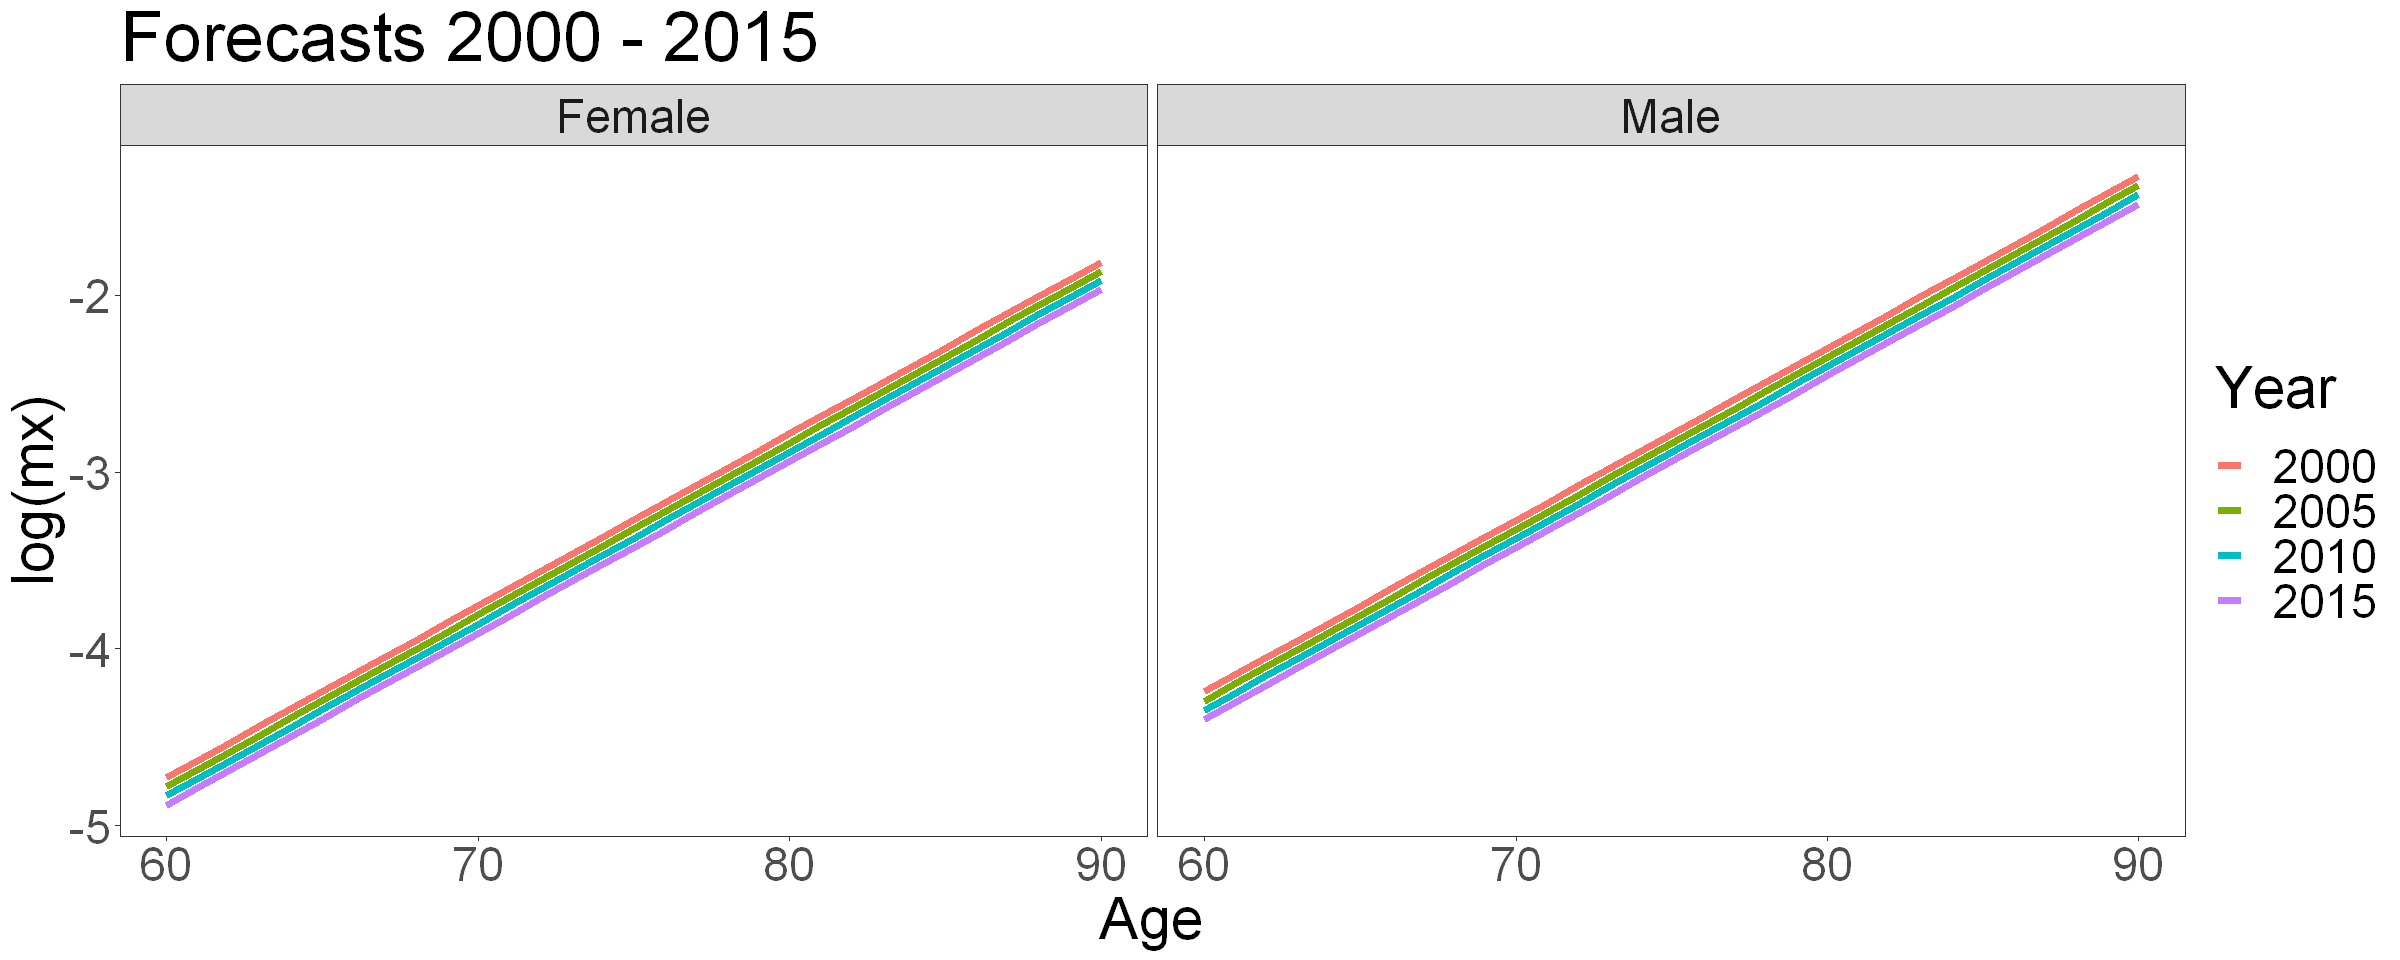

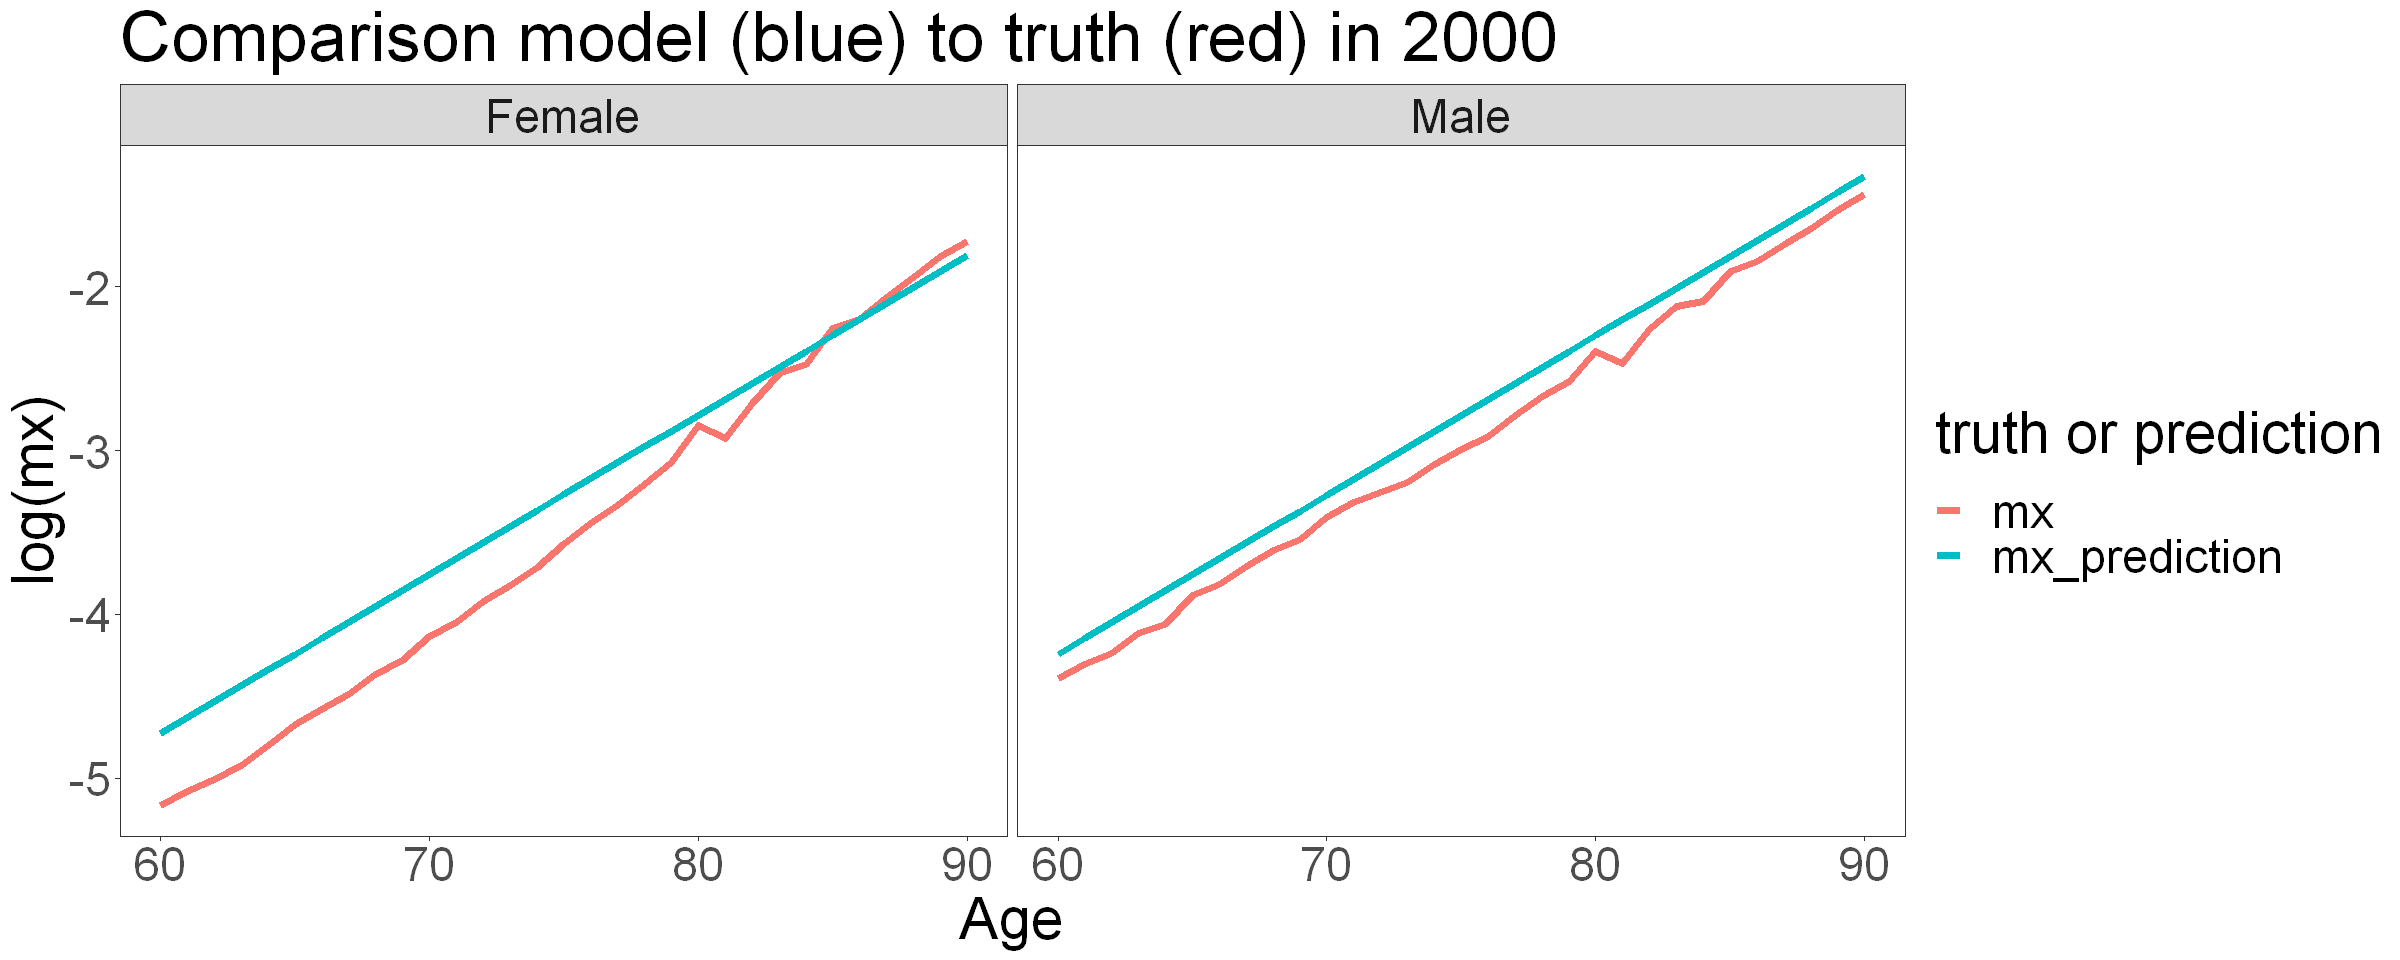

[1] "Total error measures"


MSE,MAPE
<dbl>,<dbl>
0.000241,0.2859


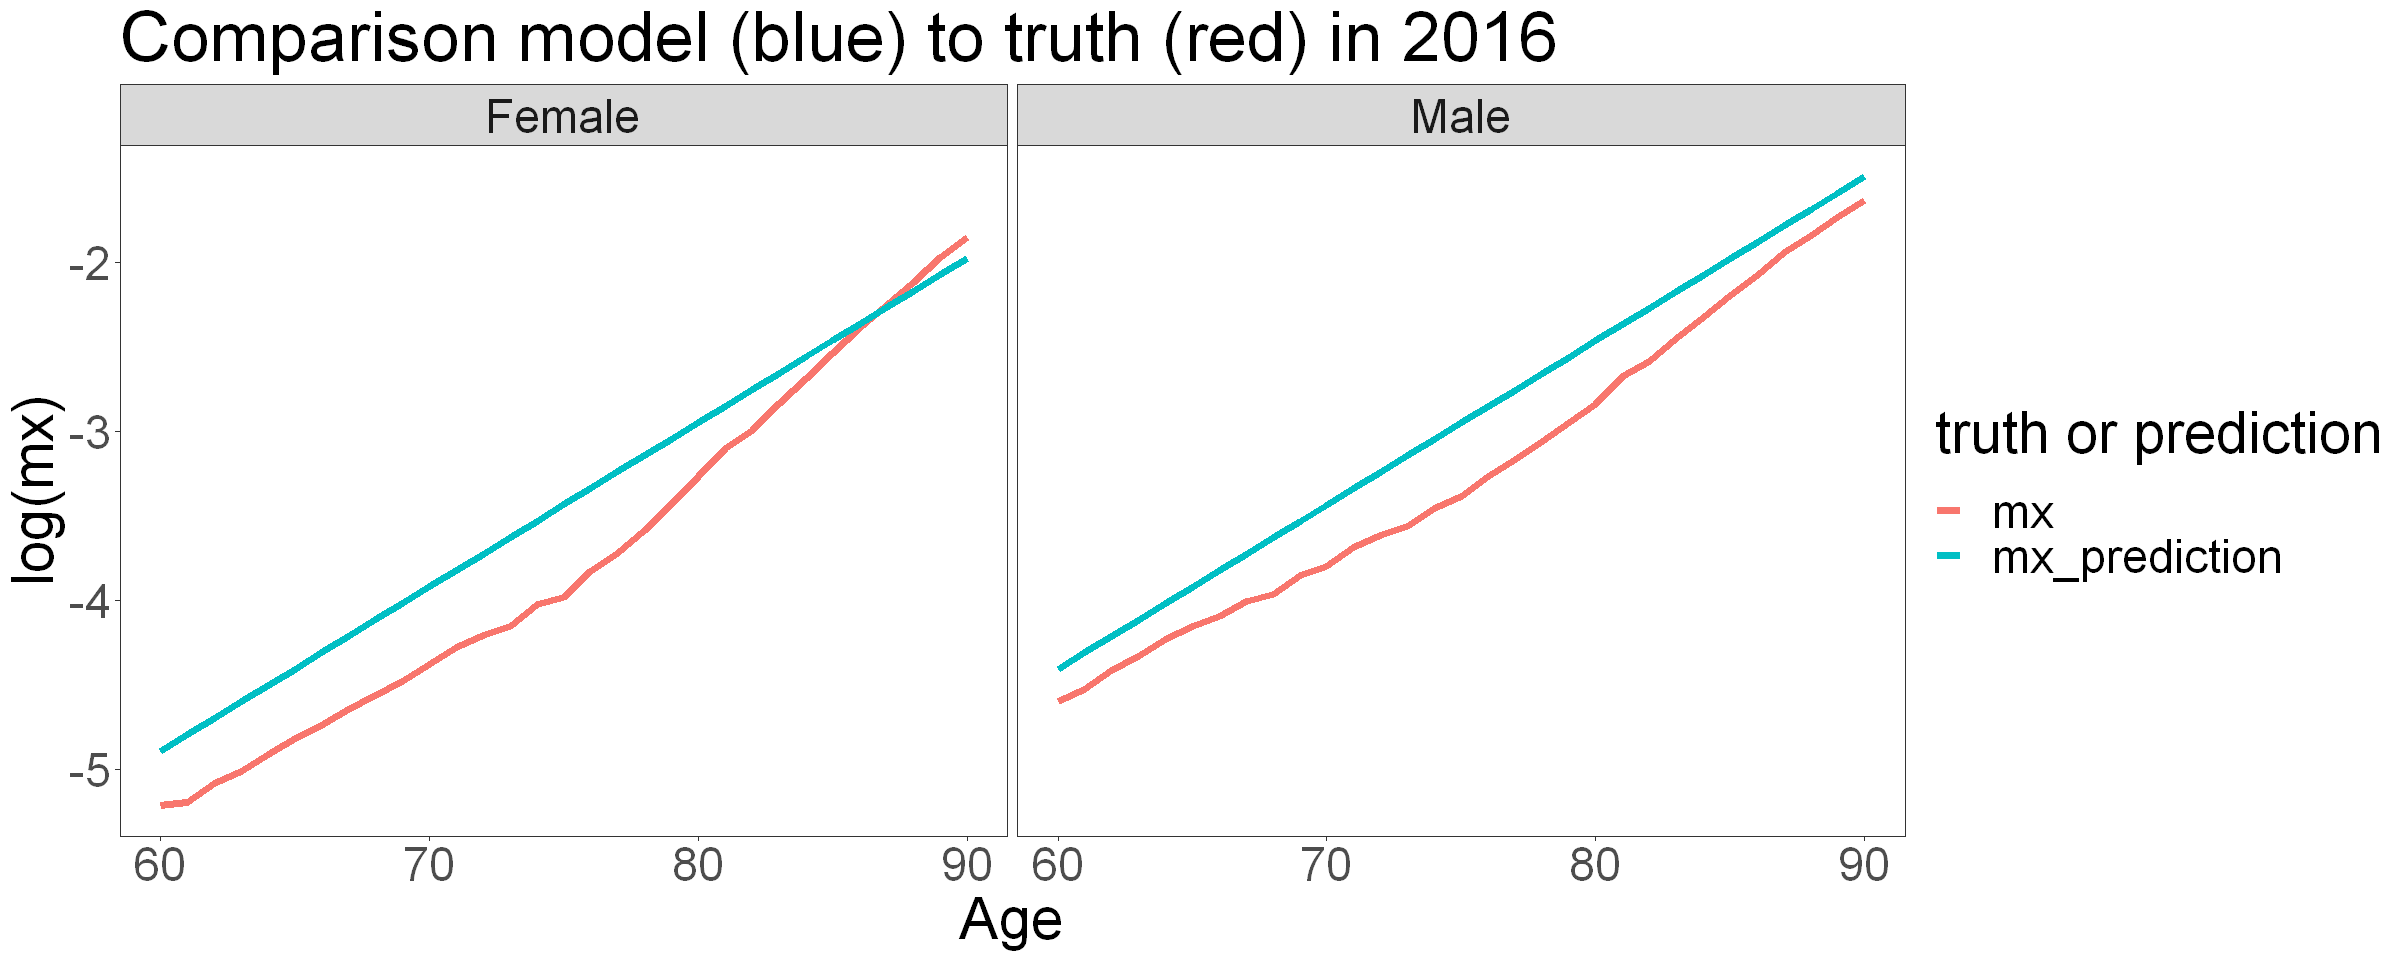

In [30]:
plot_all_forecasts(cann_prediction, country = "DEUTNP", years = seq(2000, 2015, by = 5))
plot_comparison_for_year(cann_prediction, country = "DEUTNP", year = 2000)
plot_comparison_for_year(cann_prediction, country = "DEUTNP", year = 2016)

print("Total error measures")
# MSE is not comparable to that of most of the other models because we focus on age range 60-90 here
cann_errors_total <- calculate_error_measures(cann_prediction, groups = NULL)
cann_errors_total

# CANN is not an improvement over the ordinary GLM for the age range 60-90
# ideas for further experiments: 
# - make the comparison for the whole age range 0-100
# - perform hyperparameter tuning for the NN part

### Compare in-sample Poisson deviance of GLM and CANN

In [31]:
calculate_poisson_deviance <- function(data) {
  data %>%
    dplyr::summarize(deviance = 2 * mean(Dx * log(mx / mx_prediction) + Dx * mx_prediction / mx - Dx)) %>% 
    dplyr::pull(deviance)
} 

df_train_glm <- df_train_glm %>%
  dplyr::mutate(mx_prediction = model_glm %>% predict(df_train_glm, type = "response") / Ex)
print("Poisson deviance GLM:")
calculate_poisson_deviance(df_train_glm) 
df_train_glm <- df_train_glm %>%
  dplyr::mutate(mx_prediction = model_cann %>% predict(cann_x_train_mat, type = "response") / Ex)
print("Poisson deviance CANN:")
calculate_poisson_deviance(df_train_glm)

[1] "Poisson deviance GLM:"


[1] 80.81329

[1] "Poisson deviance CANN:"


[1] 80.87827

## 9. Calibrating Lee-Carter with neural networks (see Scognamiglio 2022)

### Set up the model

In [32]:
Exposure <- keras::layer_input(shape = c(dplyr::n_distinct(df_train$Age)), dtype = "float32", name = "Exposure")
Rates <- keras::layer_input(shape = c(dplyr::n_distinct(df_train$Age)), dtype = "float32", name = "Rates")
Country <- keras::layer_input(shape = c(1), dtype = "int32", name = "Country")
Sex <- keras::layer_input(shape = c(1), dtype = "int32", name = "Sex")

# set up the embedding layers
Sex_embed_ax <- Sex %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Sex), 
                         output_dim = 5, input_length = 1, name = "Sex_embed_ax") %>% 
  keras::layer_flatten()

Sex_embed_bx <- Sex %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Sex), 
                         output_dim = 5, input_length = 1, name = "Sex_embed_bx") %>% 
  keras::layer_flatten()

Country_embed_ax <- Country %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Country), 
                         output_dim = 15, input_length = 1, name = "Country_embed_ax") %>% 
  keras::layer_flatten()

Country_embed_bx <- Country %>% 
  keras::layer_embedding(input_dim = dplyr::n_distinct(df_train$Country), 
                         output_dim = 15, input_length = 1, name = "Country_embed_bx") %>% 
  keras::layer_flatten()

Ax <- list(Country_embed_ax, Sex_embed_ax) %>%
  keras::layer_concatenate() %>%
  keras::layer_dropout(0.5) %>%
  keras::layer_dense(units = dplyr::n_distinct(df_train$Age), name = "Ax")

Bx <- list(Country_embed_bx, Sex_embed_bx) %>%
  keras::layer_concatenate() %>%
  keras::layer_dropout(0.5) %>%
  keras::layer_dense(units = dplyr::n_distinct(df_train$Age), name = "Bx") %>% 
  keras::layer_reshape(c(1, dplyr::n_distinct(df_train$Age)))

Kt <- Rates %>% 
  keras::layer_dense(units = 64, activation = "tanh") %>% 
  keras::layer_batch_normalization() %>% 
  keras::layer_dropout(0.05) %>% 
    
  keras::layer_dense(units = 32, activation = "tanh") %>% 
  keras::layer_batch_normalization() %>% 
  keras::layer_dropout(0.05) %>%  

  keras::layer_dense(units = 1, activation = "linear", name = "Kt") %>%
  keras::layer_reshape(c(1, 1))

Bx_kt <- list(Bx, Kt) %>%
  keras::layer_dot(axes = 1) %>%
  keras::layer_dropout(0.05) %>%
  keras::layer_flatten()

Rates_fc = list(Ax, Bx_kt) %>%
  keras::layer_add() %>%
  keras::layer_activation("exponential", name = "Rates_fc") 
    
Deaths_fc <- list(Rates_fc, Exposure) %>%
  keras::layer_multiply(name = "Deaths_fc")
    
model_lc_nn <- keras::keras_model(inputs = c(Rates, Country, Sex, Exposure), outputs = Deaths_fc)    

### Set up data

In [33]:
# convert input into arrays
lc_nn_x_train <- df_train_numeric %>% 
  dplyr::select(Year, Age, Country, Sex, mx, Ex, Dx) %>% 
  dplyr::arrange(Country, Sex, Year) 

lc_nn_x_train_mx <- lc_nn_x_train %>%
  dplyr::select(Year, Age, Country, Sex, mx) %>%
  tidyr::pivot_wider(id_cols = c("Year", "Country", "Sex"), names_from = "Age", values_from = "mx") 

head(lc_nn_x_train_mx)

lc_nn_x_train_Ex <- lc_nn_x_train %>%
  dplyr::select(Year, Age, Country, Sex, Ex) %>%
  tidyr::pivot_wider(id_cols = c("Year", "Country", "Sex"), names_from = "Age", values_from = "Ex") 
                           
lc_nn_x_train_mat <- list(as.matrix(lc_nn_x_train_mx %>% dplyr::select(-dplyr::one_of(c("Year", "Country", "Sex")))),
                          as.matrix(lc_nn_x_train_mx$Country),
                          as.matrix(lc_nn_x_train_mx$Sex),
                          as.matrix(lc_nn_x_train_Ex %>% dplyr::select(-dplyr::one_of(c("Year", "Country", "Sex")))))

lc_nn_x_test <- df_test_numeric %>% 
  dplyr::select(Year, Age, Country, Sex, Ex, Dx)                              

# prepare the output and convert it into an array
lc_nn_y_train <- lc_nn_x_train %>%
  dplyr::select(Year, Age, Country, Sex, Dx) %>%
  tidyr::pivot_wider(id_cols = c("Year", "Country", "Sex"), names_from = "Age", values_from = "Dx") %>%
  dplyr::select(-dplyr::one_of(c("Year", "Country", "Sex")))
lc_nn_y_train_mat <- as.matrix(lc_nn_y_train)

Year,Country,Sex,0,1,2,3,4,5,6,⋯,91,92,93,94,95,96,97,98,99,100
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1950,0,0,0.022343,0.002739,0.001019,0.000965,0.000616,0.000773,0.000616,⋯,0.261385,0.290251,0.294143,0.366196,0.352645,0.425764,0.476196,0.724572,0.655419,0.589684
1951,0,0,0.022978,0.002891,0.001696,0.000977,0.000825,0.000728,0.000607,⋯,0.236087,0.289979,0.316598,0.319815,0.426482,0.373911,0.434628,0.669969,0.304196,0.691840
1952,0,0,0.021290,0.002950,0.001371,0.000894,0.000756,0.000617,0.000648,⋯,0.242334,0.287855,0.337168,0.350559,0.341456,0.403915,0.538798,0.481992,0.492698,0.572225
1953,0,0,0.021159,0.002590,0.001413,0.000958,0.000852,0.000793,0.000568,⋯,0.238769,0.297997,0.360195,0.317486,0.369000,0.435877,0.302243,0.389402,0.598074,0.684463
1954,0,0,0.019823,0.002485,0.001224,0.000754,0.000636,0.000537,0.000560,⋯,0.246253,0.271017,0.307908,0.327092,0.286587,0.411280,0.492851,0.551976,0.451170,0.434499
1955,0,0,0.019690,0.002258,0.001218,0.000933,0.000903,0.000566,0.000521,⋯,0.249841,0.264882,0.284996,0.363427,0.362935,0.328985,0.406292,0.584084,0.636387,0.445154


### Train (can take a few hours)

In [34]:
model_lc_nn %>%
    keras::compile(optimizer = "adam", loss = "poisson") 

if (USE_TRAINED_MODELS && file.exists("models/lc_nn.h5")) {
    model_lc_nn <- keras::load_model_hdf5("models/lc_nn.h5")
} else {
    model_lc_nn %>%
        fit(x = lc_nn_x_train_mat, y = lc_nn_y_train_mat, epochs = 200) 

    keras::save_model_hdf5(model_lc_nn, "models/lc_nn.h5")
}

### Extract LC parameters from the NN and predict

In [35]:
ax_nn_model <- keras::keras_model(inputs = model_lc_nn$inputs, outputs = model_lc_nn$get_layer("Ax")$output)
bx_nn_model <- keras::keras_model(inputs = model_lc_nn$inputs, outputs = model_lc_nn$get_layer("Bx")$output)
kt_nn_model <- keras::keras_model(inputs = model_lc_nn$inputs, outputs = model_lc_nn$get_layer("Kt")$output)

# identify first row of each population
population_rows <- c(1, which(paste(lc_nn_x_train_mx$Country, lc_nn_x_train_mx$Sex) != dplyr::lag(paste(lc_nn_x_train_mx$Country, lc_nn_x_train_mx$Sex))))

ax_nn <- predict(ax_nn_model, lc_nn_x_train_mat)
ax_nn <- ax_nn[population_rows, ]
bx_nn <- predict(bx_nn_model, lc_nn_x_train_mat)
bx_nn <- bx_nn[population_rows, ]
kt_nn <- predict(kt_nn_model, lc_nn_x_train_mat) %>% c()

# translate into LC models (population by population)
lc_nn_models <- list()
lc_nn_prediction_list <- list()

populations <- df_train %>% 
  dplyr::arrange(Country, Sex, Year) %>%
  dplyr::mutate(Population = paste(Country, Sex, sep = "-")) %>%
  dplyr::pull(Population) %>%
  unique() 

for (i in seq_len(length(populations))) {
    ax <- ax_nn[i, ]
    bx <- bx_nn[i, ]
    if (i == length(populations)) {
        kt_indices <- population_rows[i]:length(kt_nn)
    } else {
        kt_indices <- population_rows[i]:(population_rows[i + 1] - 1)
    }
    kt <- kt_nn[kt_indices]
    
    # implement identifiability constraints
    c1 <- mean(kt)
    c2 <- sum(bx)
        
    ax <- ax + c1 * bx
    bx <- bx / c2
    kt <- (kt - c1) * c2
    
    # save model 
    df_train_local <- df_train %>% 
        dplyr::filter(paste(Country, Sex, sep = "-") == populations[i]) 
    names(ax) <- unique(df_train$Age)
    names(bx) <- unique(df_train$Age)
    names(kt) <- unique(df_train_local$Year)
    
    model <- list(ax = ax, bx = bx, kt = kt)
    lc_nn_models[[populations[i]]] <- model
    
    # predict
    df_test_local <- df_test %>%
        dplyr::filter(paste(Country, Sex, sep = "-") == populations[i]) 
    n_forecast_years <- dplyr::n_distinct(df_test_local$Year)
    kt_forecast <- extrapolate_kt_rwd(model$kt, n_forecast_years)
    df_test_local$mx_prediction <- forecast_LC_based_on_kt(model, kt_forecast)
    lc_nn_prediction_list[[populations[i]]] <- df_test_local
}

lc_nn_prediction <- data.table::rbindlist(lc_nn_prediction_list)

### Plot LC_NN parameters

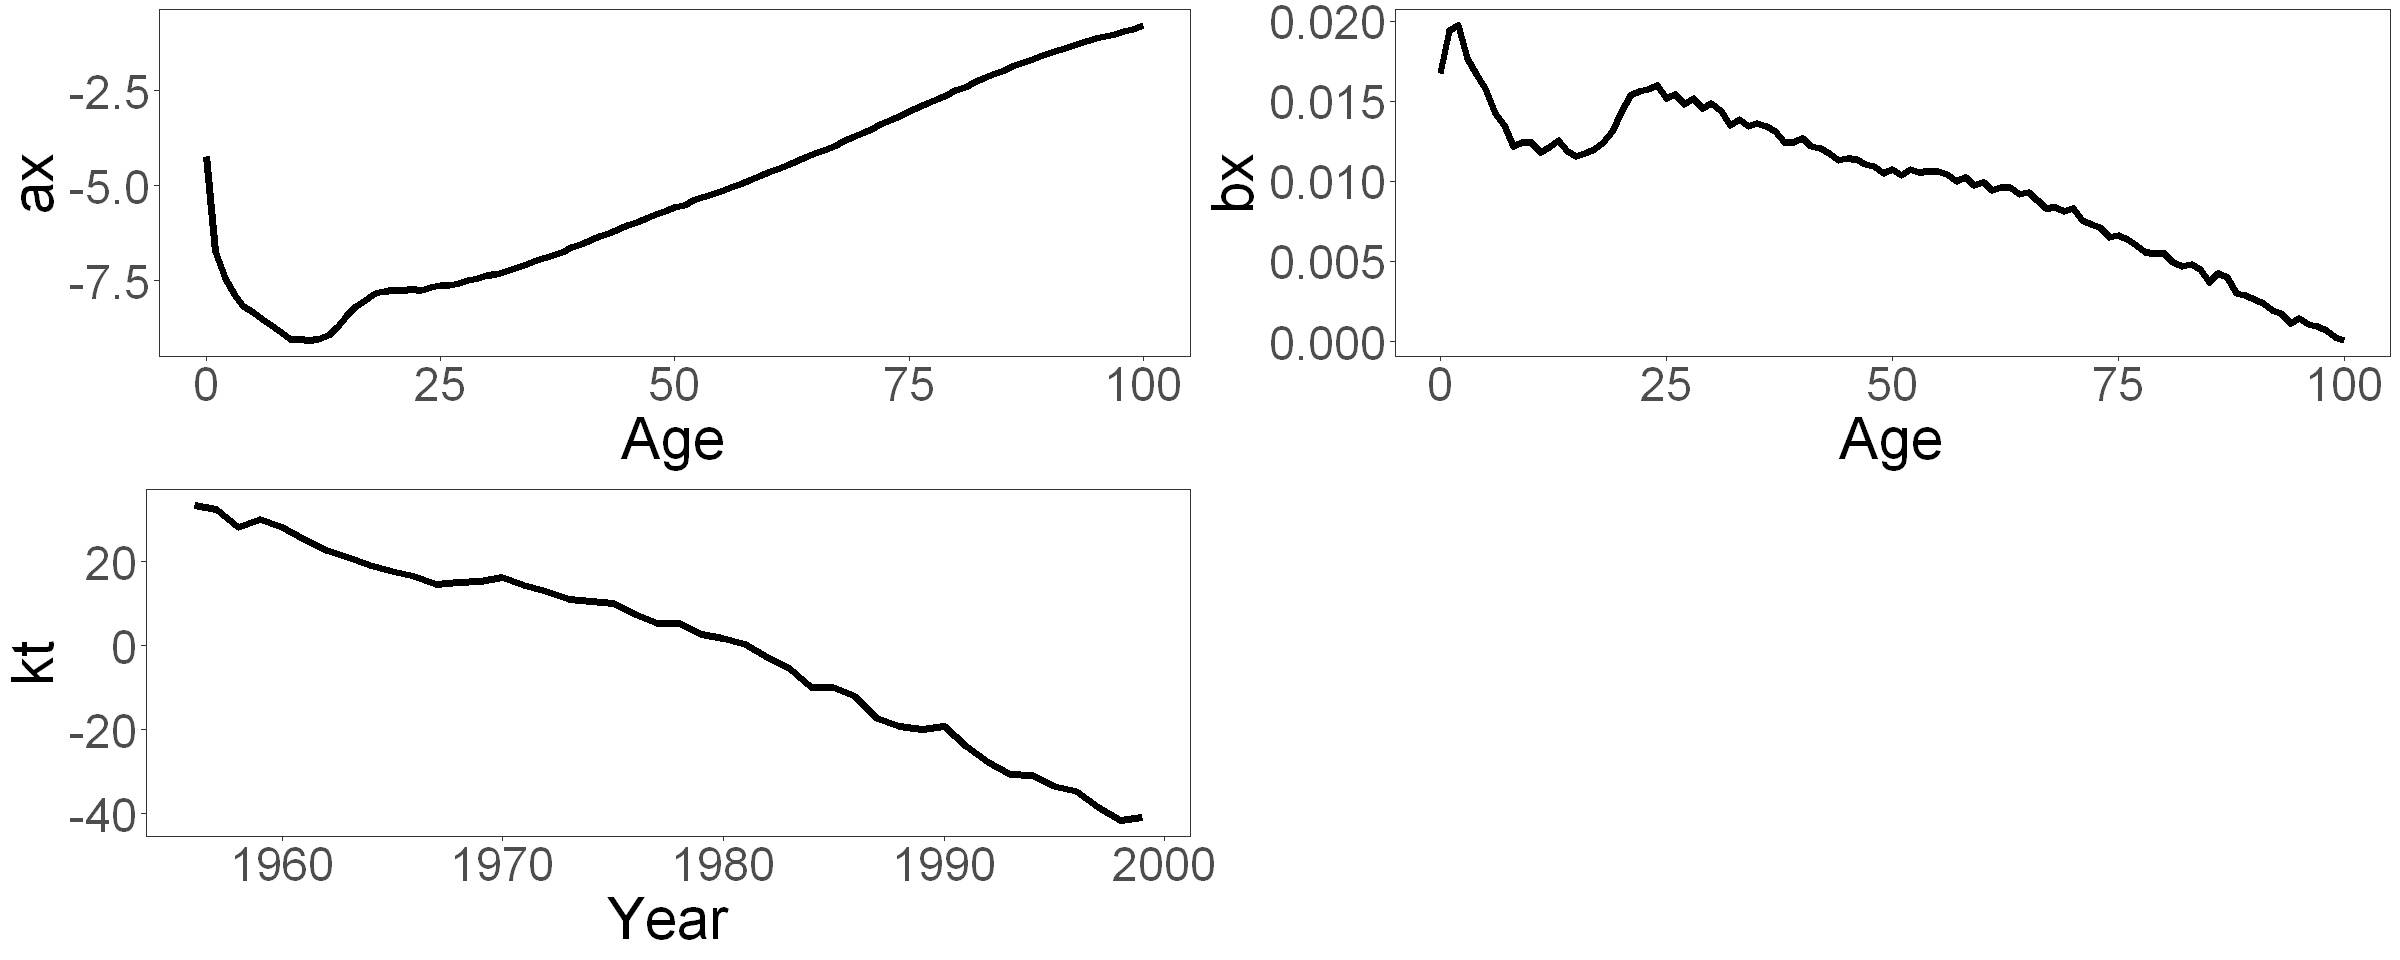

In [36]:
plot_LC_parameters(lc_nn_models[["DEUTNP-Female"]]) 

### LC_NN forecasts and error measures
(we need exposures to predict death rates in this model, so we cannot forecast beyond 2016)

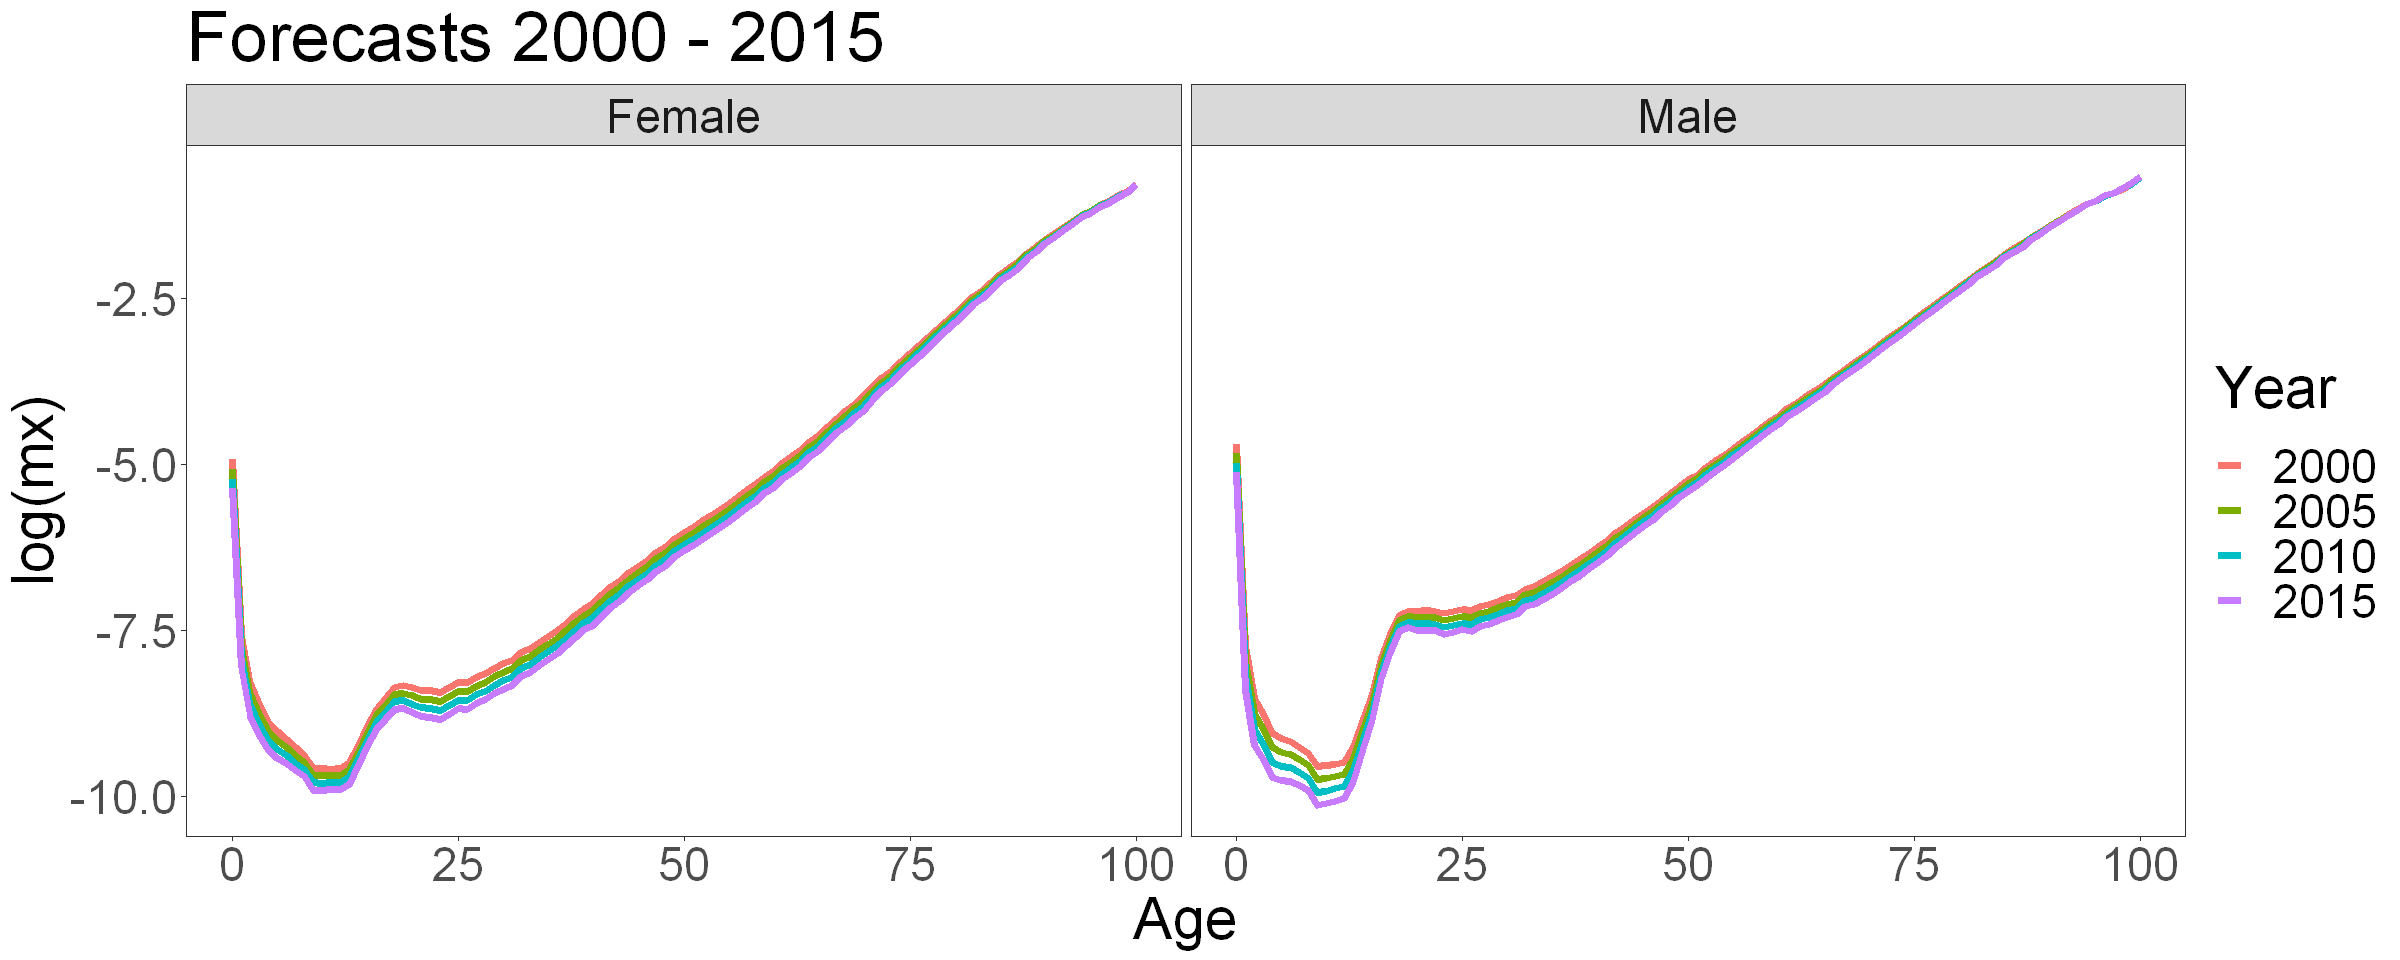

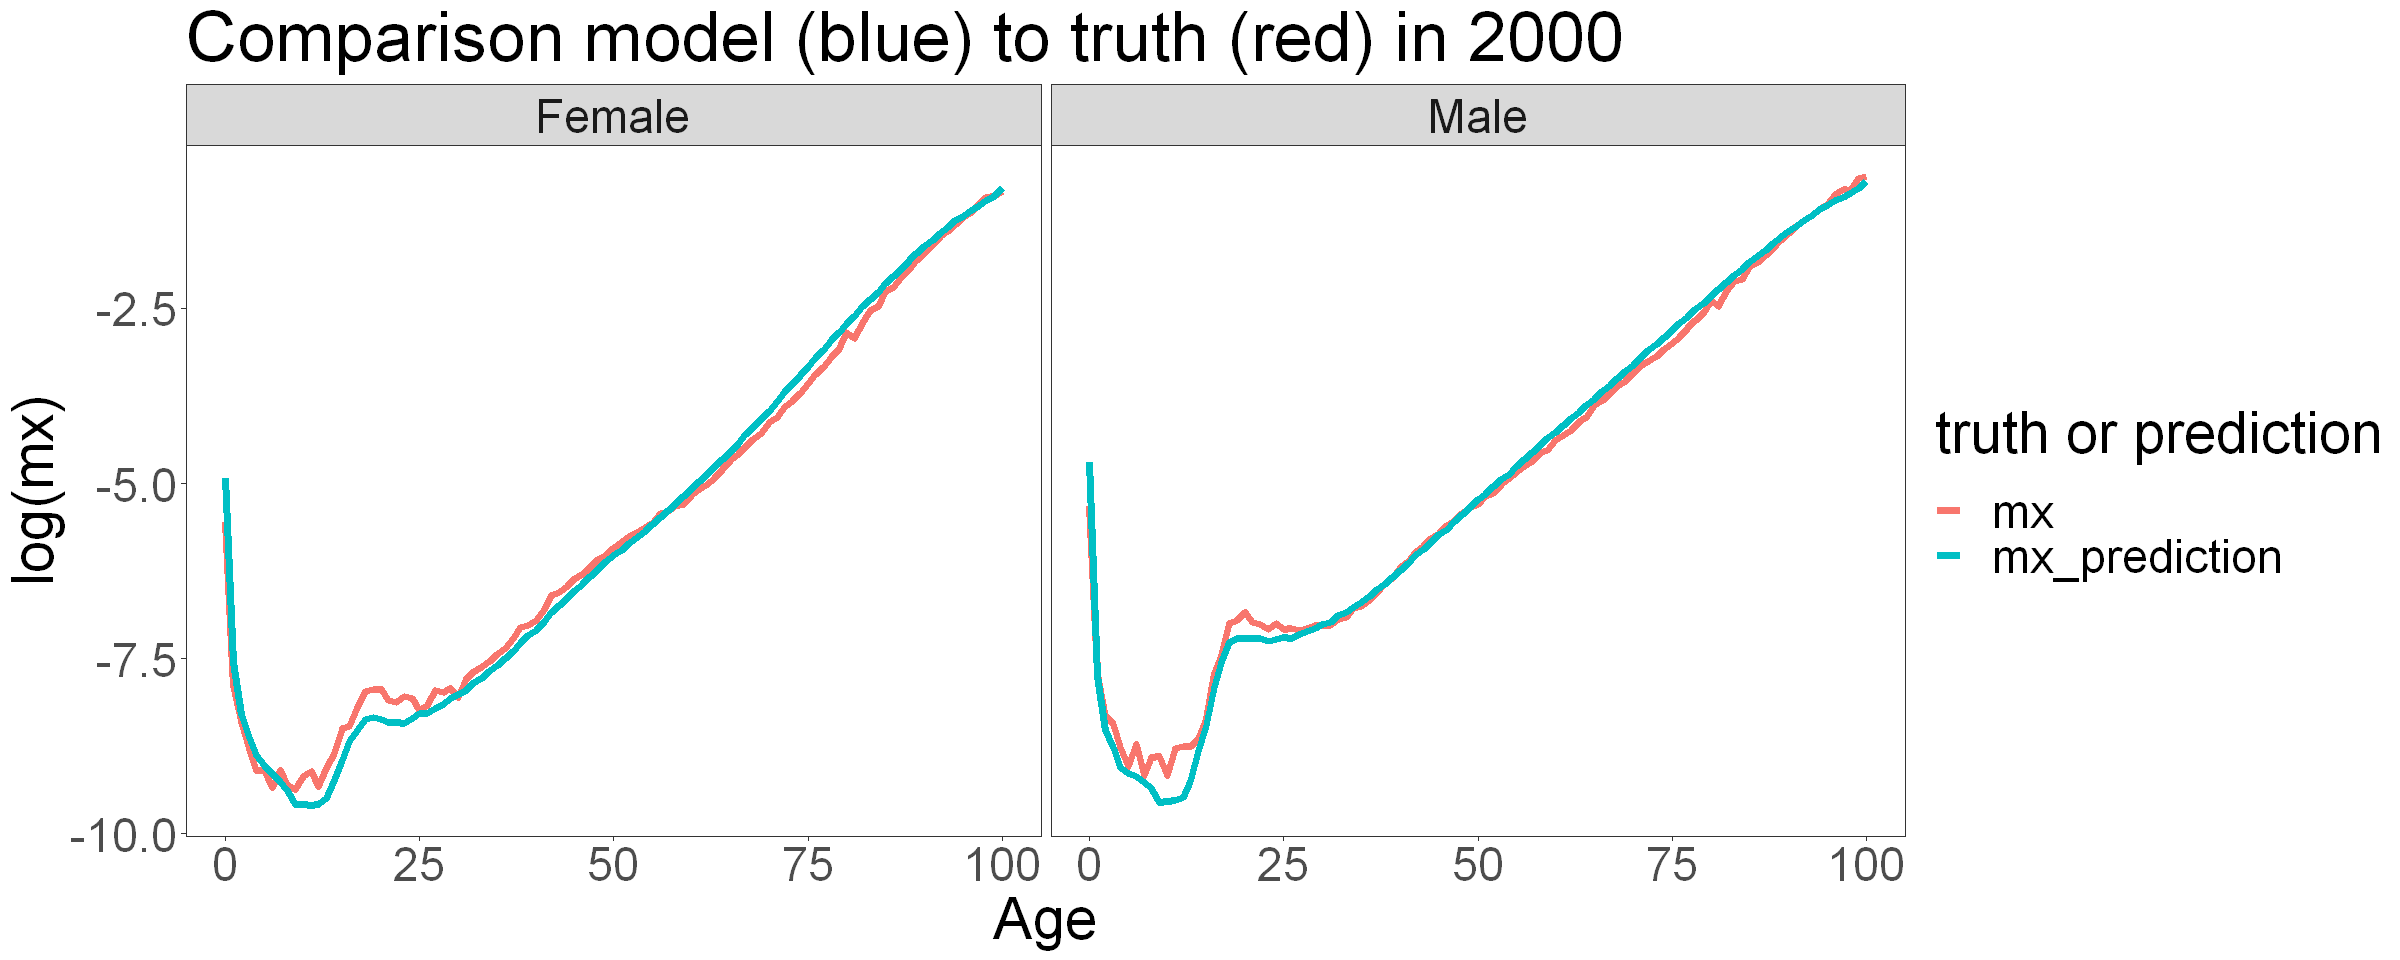

[1] "Total error measures"


MSE,MAPE
<dbl>,<dbl>
0.000583,0.3651


[1] "Error measures by country-sex group"


Country,Sex,MSE,MAPE
<chr>,<chr>,<dbl>,<dbl>
CAN,Female,0.000036,0.1271
CHL,Female,0.000090,0.1288
FRATNP,Female,0.000083,0.1585
ESP,Female,0.000037,0.1778
DEUTNP,Female,0.000092,0.1786
ITA,Female,0.000043,0.1821
FRATNP,Male,0.000151,0.2099
DEUTNP,Male,0.000213,0.2225
GRC,Male,0.000321,0.2266


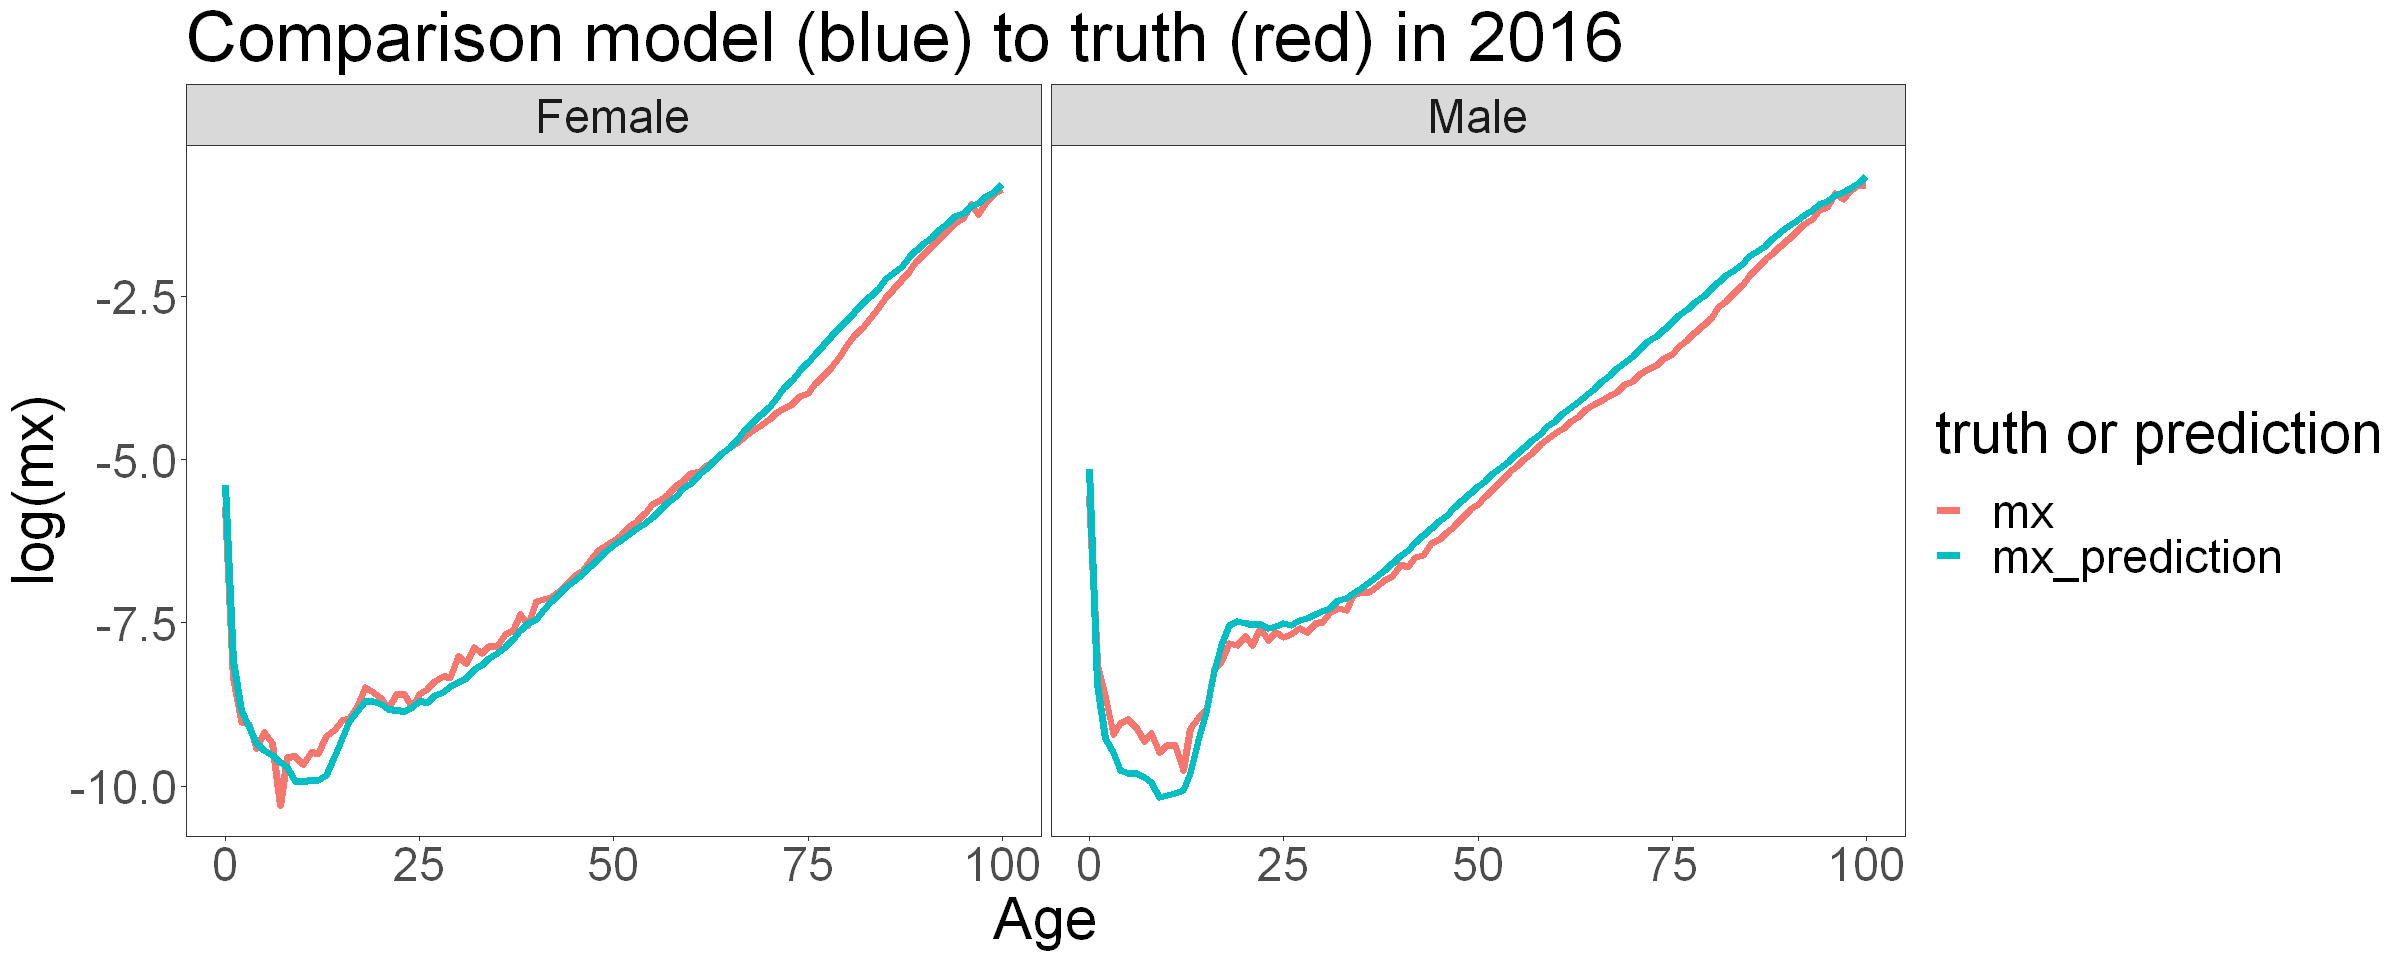

In [37]:
plot_all_forecasts(lc_nn_prediction, country = "DEUTNP", years = seq(2000, 2015, by = 5))
plot_comparison_for_year(lc_nn_prediction, country = "DEUTNP", year = 2000)
plot_comparison_for_year(lc_nn_prediction, country = "DEUTNP", year = 2016)

print("Total error measures")
lc_nn_errors_total <- calculate_error_measures(lc_nn_prediction, groups = NULL)
lc_nn_errors_total

print("Error measures by country-sex group")
lc_nn_errors_grouped <- calculate_error_measures(lc_nn_prediction, groups = c("Country", "Sex")) %>% 
  dplyr::arrange(MAPE)
lc_nn_errors_grouped 